# Main Notebook

File to perform experiments

## Imports

In [1]:
import os
import numpy as np
import gpflow
import matplotlib.pyplot as plt
import pandas as pd
import time
from tqdm import tqdm
import tensorflow as tf

from models.GaussianProcess import GaussianProcess
from acquisition_functions.UseMO import usemo_acq
from acquisition_functions.MES import mes_acq, basic_mes_acq
from acquisition_functions.PESMO import pesmo_acq
from acquisition_functions.MESMO import mesmo_acq
from arguments.arguments import MainArguments

from MOObenchmark import MOOackley, MOOexponential, MOOquadratic_ackley, MOOnnHousesRegression
from utils.calc_pareto import get_pareto_undominated_by, getSetfromFront

from models.MOOEvaluationProblem import MOOEvaluationProblem

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_termination
from pymoo.optimize import minimize

2023-06-12 23:09:46.130952: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-12 23:09:46.209535: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-12 23:09:46.210879: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-12 23:09:47.479996: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Algorithm Arguments

In [2]:
d = 2 # input dimensions
    
seed = 1
np.random.seed(seed)

## iterations of the main algorithm
total_iter = 100
## iterations taken randomly at the beggining
initial_iter = 1

## bound of the inputs definition
### with the current implementations all the input dimensions must have the same bounds, 
### but this can be changed
lower_bound = 10
upper_bound = 1000

lowerBounds = [lower_bound]*d
upperBounds = [upper_bound]*d


## Evaluation

In [3]:
## Evaluation function definition
O = 2
C = 0

def evaluation(x):
    return MOOnnHousesRegression(x)

This cell below gets the real pareto in two ways: with a grid and with a cheap optimizer (genetic algorithm) and plots both of them. These results are used in test problems as the actual pareto front. Although, to obtain these paretos many evaluations of the function are needed, so it has no sense running it in a costly black box problem.

In addition this is only prepared to plot a d=1, O=2 problem. We could visualize any problem, but the visualization get a lot more abstract and more plots are needed. If this is interesting I could do it.

Therefore I set the code below as text.

N = 1_001
X = np.linspace(lower_bound,upper_bound,N)
Z = np.zeros((N,2))

problem = MOOEvaluationProblem(evaluation, O=O, d=d, lowerBounds=lower_bound, upperBounds=upper_bound)
algorithm = NSGA2()
res = minimize( problem, 
                algorithm,
                termination = get_termination("n_gen",100))

real_pareto = res.F[np.argsort(res.F[:,0])]

for i in range(N):
    Z[i]=evaluation(X[i])

fig, axs = plt.subplots(1,3, figsize=(15,4))

axs[0].plot(X, Z[:,0], 'b')
axs[0].plot(X, Z[:,1], 'k')
axs[0].plot(res.X, res.F[:,0], 'xr', markersize=5)
axs[0].plot(res.X, res.F[:,1], 'xr', markersize=5)

axs[1].plot(np.reshape(Z,(-1,2))[:,0], np.reshape(Z,(-1,2))[:,1], 'kx')
axs[1].plot(res.F[:,0], res.F[:,1], 'rx')
res
axs[2].plot(res.F[:,0], res.F[:,1], 'x')
plt.show()

In [4]:
def random_acq(GP: GaussianProcess, **kwargs):
    while True:
        x_rand = np.random.uniform(GP.lowerBounds, GP.upperBounds, GP.d)
        if GP.X is None or not x_rand in GP.X:
            break
    return x_rand, 0

## N experiments

C = [422.85178466 723.12124851]
Epoch 1/6
517/517 [==============================] - 5s 7ms/step - loss: 113464934400.0000 - mae: 213065.8281 - mse: 113464729600.0000 - val_loss: 62986977280.0000 - val_mae: 165813.2812 - val_mse: 62986780672.0000
Epoch 2/6
517/517 [==============================] - 3s 6ms/step - loss: 61189935104.0000 - mae: 164204.0781 - mse: 61189763072.0000 - val_loss: 55850885120.0000 - val_mae: 162433.2344 - val_mse: 55850725376.0000
Epoch 3/6
517/517 [==============================] - 3s 7ms/step - loss: 58605576192.0000 - mae: 161389.8438 - mse: 58605400064.0000 - val_loss: 54247272448.0000 - val_mae: 156999.5625 - val_mse: 54247129088.0000
Epoch 4/6
517/517 [==============================] - 4s 7ms/step - loss: 56927186944.0000 - mae: 158534.3750 - mse: 56927010816.0000 - val_loss: 55428386816.0000 - val_mae: 152857.8750 - val_mse: 55428235264.0000
Epoch 5/6
517/517 [==============================] - 3s 6ms/step - loss: 56731058176.0000 - mae: 157386.0469 - mse

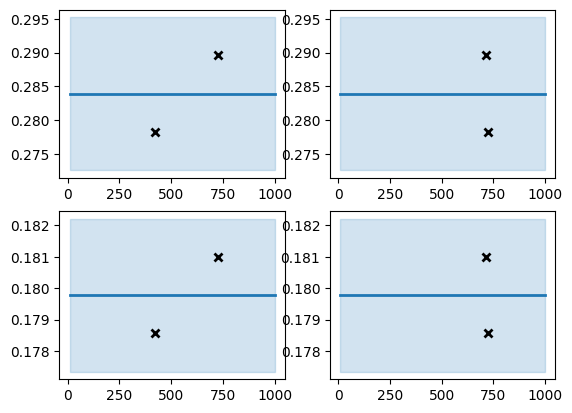

x_best =  [806.79822429 635.08349465]
acq_best =  [0.00225058 0.00048437]
C = [806.79822429 635.08349465]
Epoch 1/6
517/517 [==============================] - 8s 13ms/step - loss: 103972044800.0000 - mae: 206148.5781 - mse: 103971823616.0000 - val_loss: 58555031552.0000 - val_mae: 162838.9375 - val_mse: 58554880000.0000
Epoch 2/6
517/517 [==============================] - 5s 9ms/step - loss: 60509302784.0000 - mae: 163703.9375 - mse: 60509134848.0000 - val_loss: 55031664640.0000 - val_mae: 153659.5469 - val_mse: 55031508992.0000
Epoch 3/6
517/517 [==============================] - 5s 10ms/step - loss: 58603827200.0000 - mae: 161489.8906 - mse: 58603667456.0000 - val_loss: 62951849984.0000 - val_mae: 158947.5938 - val_mse: 62951686144.0000
Epoch 4/6
517/517 [==============================] - 5s 9ms/step - loss: 58902753280.0000 - mae: 161949.1094 - mse: 58902597632.0000 - val_loss: 55305019392.0000 - val_mae: 160944.5000 - val_mse: 55304855552.0000
Epoch 5/6
517/517 [===================

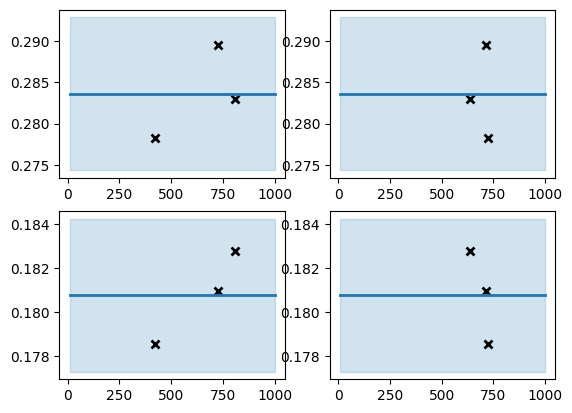

x_best =  [422.83618539 723.13078364]
acq_best =  [4.21050854e-06 3.45513911e-04]
C = [422.83618539 723.13078364]
Epoch 1/6
517/517 [==============================] - 5s 8ms/step - loss: 116032077824.0000 - mae: 213397.2500 - mse: 116031889408.0000 - val_loss: 82198863872.0000 - val_mae: 178402.3125 - val_mse: 82198675456.0000
Epoch 2/6
517/517 [==============================] - 3s 6ms/step - loss: 62512287744.0000 - mae: 164769.7969 - mse: 62512103424.0000 - val_loss: 54820425728.0000 - val_mae: 157909.9062 - val_mse: 54820261888.0000
Epoch 3/6
517/517 [==============================] - 3s 5ms/step - loss: 59210014720.0000 - mae: 162039.6562 - mse: 59209863168.0000 - val_loss: 54409838592.0000 - val_mae: 154697.9375 - val_mse: 54409682944.0000
Epoch 4/6
517/517 [==============================] - 3s 5ms/step - loss: 58457628672.0000 - mae: 160963.1719 - mse: 58457444352.0000 - val_loss: 54094561280.0000 - val_mae: 152520.5938 - val_mse: 54094417920.0000
Epoch 5/6
517/517 [=============

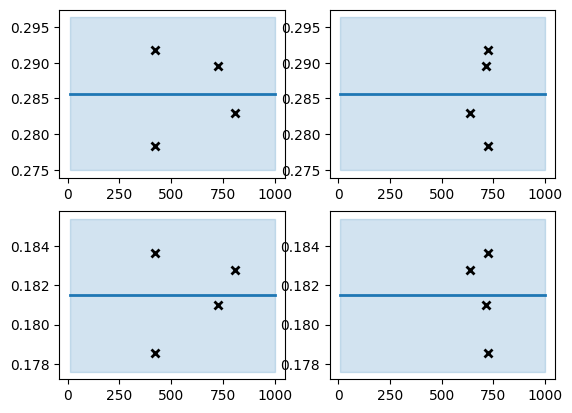

x_best =  [172.88563947 226.83506213]
acq_best =  [0.00212993 0.00077599]
C = [172.88563947 226.83506213]
Epoch 1/6
517/517 [==============================] - 3s 3ms/step - loss: 133069357056.0000 - mae: 232454.8906 - mse: 133069086720.0000 - val_loss: 100340645888.0000 - val_mae: 205408.3125 - val_mse: 100340457472.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 72972795904.0000 - mae: 172826.7500 - mse: 72972599296.0000 - val_loss: 63166705664.0000 - val_mae: 179448.8906 - val_mse: 63166529536.0000
Epoch 3/6
517/517 [==============================] - 1s 3ms/step - loss: 60561215488.0000 - mae: 162523.3438 - mse: 60561051648.0000 - val_loss: 54879764480.0000 - val_mae: 155461.2344 - val_mse: 54879580160.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 58483298304.0000 - mae: 159105.4375 - mse: 58483134464.0000 - val_loss: 52792315904.0000 - val_mae: 152585.3906 - val_mse: 52792176640.0000
Epoch 5/6
517/517 [===================

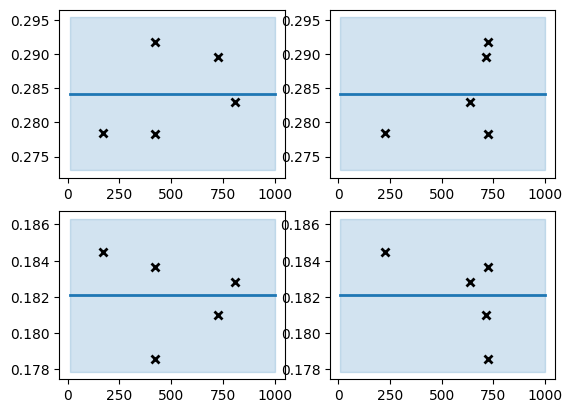

x_best =  [557.72057746 347.00528063]
acq_best =  [0.00223112 0.00084124]
C = [557.72057746 347.00528063]
Epoch 1/6
517/517 [==============================] - 2s 3ms/step - loss: 116192100352.0000 - mae: 216176.5156 - mse: 116191895552.0000 - val_loss: 67618299904.0000 - val_mae: 161672.0938 - val_mse: 67618131968.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 63724216320.0000 - mae: 167009.7812 - mse: 63724081152.0000 - val_loss: 57943445504.0000 - val_mae: 167014.8594 - val_mse: 57943293952.0000
Epoch 3/6
517/517 [==============================] - 1s 3ms/step - loss: 59871277056.0000 - mae: 162585.6094 - mse: 59871113216.0000 - val_loss: 57087713280.0000 - val_mae: 167449.2812 - val_mse: 57087569920.0000
Epoch 4/6
517/517 [==============================] - 2s 5ms/step - loss: 58363584512.0000 - mae: 161111.1875 - mse: 58363392000.0000 - val_loss: 54285975552.0000 - val_mae: 153054.4375 - val_mse: 54285819904.0000
Epoch 5/6
517/517 [=====================

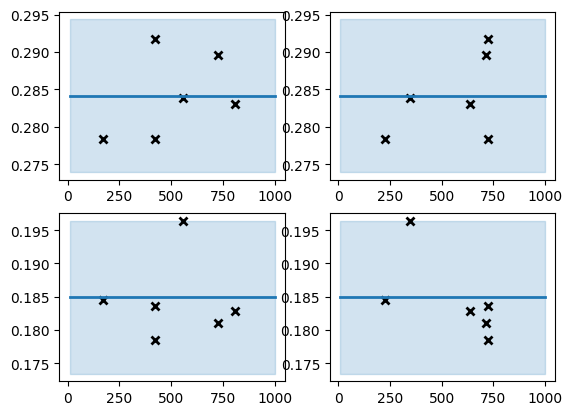

x_best =  [806.79310173 635.08409669]
acq_best =  [0.00186335 0.00137658]
C = [806.79310173 635.08409669]
Epoch 1/6
517/517 [==============================] - 6s 9ms/step - loss: 102074073088.0000 - mae: 203490.9375 - mse: 102073835520.0000 - val_loss: 59558051840.0000 - val_mae: 162788.9062 - val_mse: 59557879808.0000
Epoch 2/6
517/517 [==============================] - 5s 9ms/step - loss: 60138795008.0000 - mae: 162985.9375 - mse: 60138606592.0000 - val_loss: 55957921792.0000 - val_mae: 161973.9375 - val_mse: 55957737472.0000
Epoch 3/6
517/517 [==============================] - 5s 9ms/step - loss: 58109370368.0000 - mae: 160199.5312 - mse: 58109198336.0000 - val_loss: 54913495040.0000 - val_mae: 158927.4375 - val_mse: 54913339392.0000
Epoch 4/6
517/517 [==============================] - 6s 12ms/step - loss: 57953468416.0000 - mae: 161026.6875 - mse: 57953320960.0000 - val_loss: 53716799488.0000 - val_mae: 157623.7500 - val_mse: 53716643840.0000
Epoch 5/6
517/517 [====================

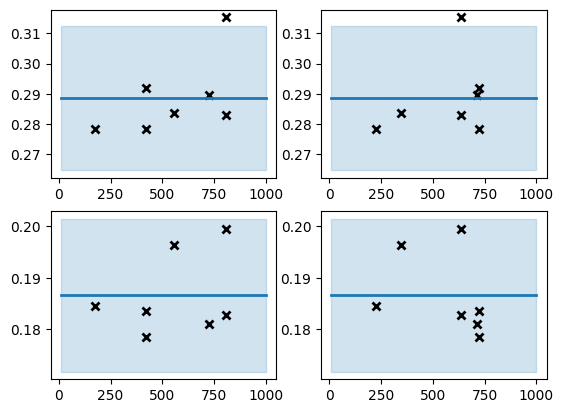

x_best =  [746.44308039 232.39154696]
acq_best =  [0.00473895 0.0029497 ]
C = [746.44308039 232.39154696]
Epoch 1/6
517/517 [==============================] - 2s 3ms/step - loss: 111373238272.0000 - mae: 212803.6250 - mse: 111373017088.0000 - val_loss: 69956722688.0000 - val_mae: 164083.4844 - val_mse: 69956591616.0000
Epoch 2/6
517/517 [==============================] - 1s 3ms/step - loss: 61345546240.0000 - mae: 163341.4062 - mse: 61345361920.0000 - val_loss: 55387557888.0000 - val_mae: 162754.1562 - val_mse: 55387389952.0000
Epoch 3/6
517/517 [==============================] - 2s 3ms/step - loss: 58245865472.0000 - mae: 160713.4844 - mse: 58245726208.0000 - val_loss: 55770296320.0000 - val_mae: 153395.8906 - val_mse: 55770144768.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 58170134528.0000 - mae: 160026.9062 - mse: 58170011648.0000 - val_loss: 55226396672.0000 - val_mae: 154468.1406 - val_mse: 55226253312.0000
Epoch 5/6
517/517 [=====================

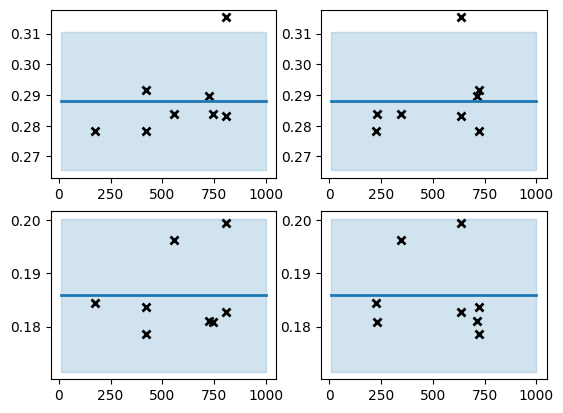

x_best =  [288.78942215 892.18923767]
acq_best =  [0.00447588 0.00285807]
C = [288.78942215 892.18923767]
Epoch 1/6
517/517 [==============================] - 5s 7ms/step - loss: 121692192768.0000 - mae: 220434.6094 - mse: 121691963392.0000 - val_loss: 76038922240.0000 - val_mae: 168738.7031 - val_mse: 76038791168.0000
Epoch 2/6
517/517 [==============================] - 3s 6ms/step - loss: 63800877056.0000 - mae: 166063.0469 - mse: 63800733696.0000 - val_loss: 56327213056.0000 - val_mae: 157684.1250 - val_mse: 56327069696.0000
Epoch 3/6
517/517 [==============================] - 3s 6ms/step - loss: 59352825856.0000 - mae: 162096.5625 - mse: 59352662016.0000 - val_loss: 61851783168.0000 - val_mae: 162069.2031 - val_mse: 61851627520.0000
Epoch 4/6
517/517 [==============================] - 3s 5ms/step - loss: 58707836928.0000 - mae: 161275.4688 - mse: 58707685376.0000 - val_loss: 56532799488.0000 - val_mae: 159427.6094 - val_mse: 56532656128.0000
Epoch 5/6
517/517 [=====================

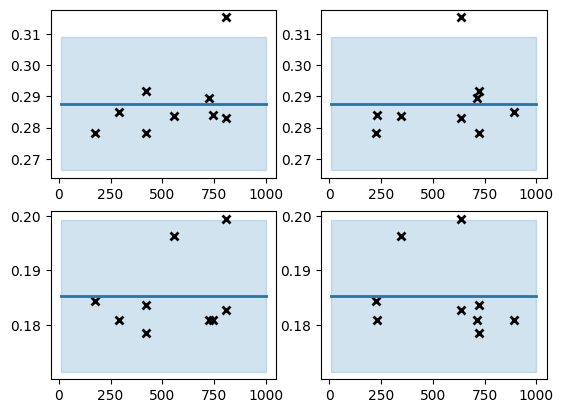

x_best =  [685.79903002 112.75709135]
acq_best =  [0.00423738 0.00276315]
C = [685.79903002 112.75709135]
Epoch 1/6
517/517 [==============================] - 3s 4ms/step - loss: 124011372544.0000 - mae: 222210.3125 - mse: 124011200512.0000 - val_loss: 79760629760.0000 - val_mae: 196196.5625 - val_mse: 79760457728.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 64898846720.0000 - mae: 165352.2812 - mse: 64898658304.0000 - val_loss: 58623025152.0000 - val_mae: 159847.4375 - val_mse: 58622869504.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 60262932480.0000 - mae: 161878.2656 - mse: 60262793216.0000 - val_loss: 57679314944.0000 - val_mae: 155830.0312 - val_mse: 57679147008.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 58052825088.0000 - mae: 159400.9219 - mse: 58052673536.0000 - val_loss: 54687113216.0000 - val_mae: 159803.8438 - val_mse: 54686945280.0000
Epoch 5/6
517/517 [=====================

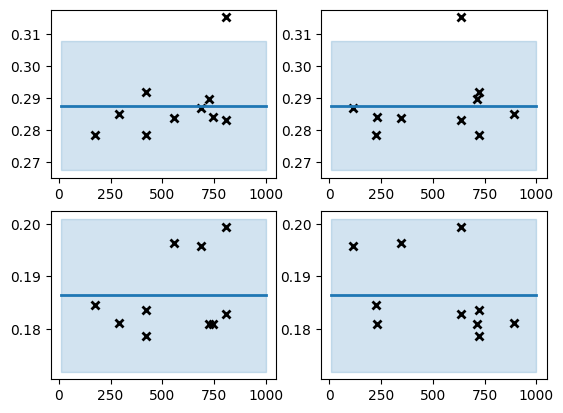

x_best =  [290.3521157  390.57649605]
acq_best =  [0.00402144 0.00290607]
C = [290.3521157  390.57649605]
Epoch 1/6
517/517 [==============================] - 2s 3ms/step - loss: 119382253568.0000 - mae: 218485.8281 - mse: 119382073344.0000 - val_loss: 71679385600.0000 - val_mae: 170687.3750 - val_mse: 71679213568.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 63806664704.0000 - mae: 165793.8594 - mse: 63806537728.0000 - val_loss: 58206396416.0000 - val_mae: 161482.8281 - val_mse: 58206240768.0000
Epoch 3/6
517/517 [==============================] - 1s 3ms/step - loss: 60279451648.0000 - mae: 163468.7969 - mse: 60279250944.0000 - val_loss: 54347886592.0000 - val_mae: 157766.3750 - val_mse: 54347722752.0000
Epoch 4/6
517/517 [==============================] - 1s 3ms/step - loss: 58156163072.0000 - mae: 160724.1562 - mse: 58155966464.0000 - val_loss: 54785851392.0000 - val_mae: 156333.7656 - val_mse: 54785687552.0000
Epoch 5/6
517/517 [=====================

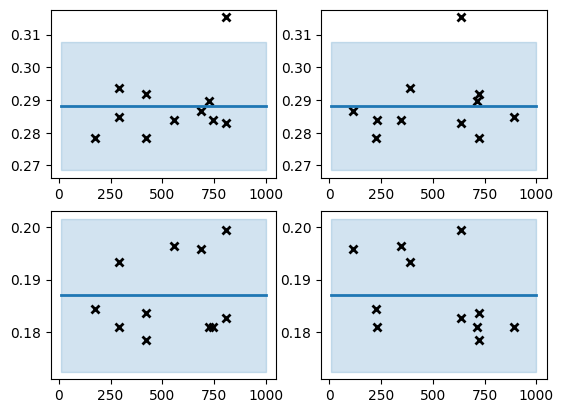

x_best =  [188.96037141 229.66869863]
acq_best =  [0.00389959 0.00288218]
C = [188.96037141 229.66869863]
Epoch 1/6
517/517 [==============================] - 2s 2ms/step - loss: 135965933568.0000 - mae: 235657.4062 - mse: 135965696000.0000 - val_loss: 108625428480.0000 - val_mae: 206865.5938 - val_mse: 108625190912.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 80168017920.0000 - mae: 178006.9688 - mse: 80167796736.0000 - val_loss: 59738042368.0000 - val_mae: 163986.5156 - val_mse: 59737866240.0000
Epoch 3/6
517/517 [==============================] - 2s 3ms/step - loss: 60493111296.0000 - mae: 162319.3125 - mse: 60492955648.0000 - val_loss: 56241647616.0000 - val_mae: 156929.4844 - val_mse: 56241500160.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 58802733056.0000 - mae: 160962.0156 - mse: 58802577408.0000 - val_loss: 54151380992.0000 - val_mae: 153953.1562 - val_mse: 54151254016.0000
Epoch 5/6
517/517 [===================

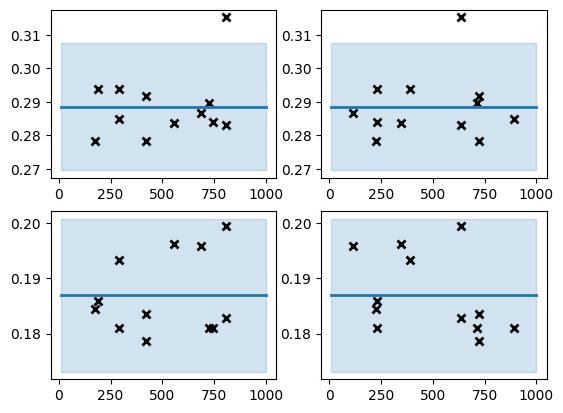

x_best =  [387.06061878 714.00050234]
acq_best =  [0.00378817 0.0027619 ]
C = [387.06061878 714.00050234]
Epoch 1/6
517/517 [==============================] - 4s 6ms/step - loss: 117830311936.0000 - mae: 217812.1719 - mse: 117830090752.0000 - val_loss: 71323541504.0000 - val_mae: 180522.7188 - val_mse: 71323336704.0000
Epoch 2/6
517/517 [==============================] - 3s 5ms/step - loss: 62906273792.0000 - mae: 165173.5156 - mse: 62906089472.0000 - val_loss: 59999580160.0000 - val_mae: 169344.1875 - val_mse: 59999416320.0000
Epoch 3/6
517/517 [==============================] - 3s 5ms/step - loss: 59302748160.0000 - mae: 162308.7656 - mse: 59302567936.0000 - val_loss: 58449674240.0000 - val_mae: 157410.9531 - val_mse: 58449494016.0000
Epoch 4/6
517/517 [==============================] - 2s 5ms/step - loss: 58185564160.0000 - mae: 160475.3438 - mse: 58185433088.0000 - val_loss: 54205591552.0000 - val_mae: 151881.9062 - val_mse: 54205431808.0000
Epoch 5/6
517/517 [=====================

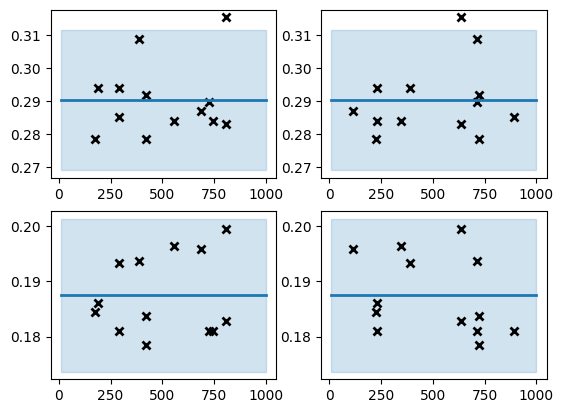

x_best =  [736.0156203   90.94349441]
acq_best =  [0.00422235 0.00274659]
C = [736.0156203   90.94349441]
Epoch 1/6
517/517 [==============================] - 2s 2ms/step - loss: 120991432704.0000 - mae: 220607.7188 - mse: 120991260672.0000 - val_loss: 76791406592.0000 - val_mae: 178144.3281 - val_mse: 76791218176.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 64603594752.0000 - mae: 165100.7656 - mse: 64603439104.0000 - val_loss: 56086716416.0000 - val_mae: 155210.0156 - val_mse: 56086548480.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 59349147648.0000 - mae: 160933.2031 - mse: 59348938752.0000 - val_loss: 56617844736.0000 - val_mae: 165234.6094 - val_mse: 56617680896.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 58137206784.0000 - mae: 159529.2812 - mse: 58137079808.0000 - val_loss: 54364844032.0000 - val_mae: 155955.7500 - val_mse: 54364688384.0000
Epoch 5/6
517/517 [=====================

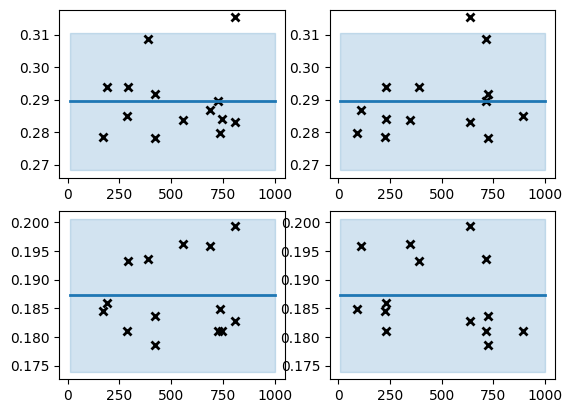

x_best =  [552.75012478 526.71874686]
acq_best =  [0.00421198 0.00266021]
C = [552.75012478 526.71874686]
Epoch 1/6
517/517 [==============================] - 4s 6ms/step - loss: 112717668352.0000 - mae: 209192.3281 - mse: 112717463552.0000 - val_loss: 63385878528.0000 - val_mae: 160304.0156 - val_mse: 63385731072.0000
Epoch 2/6
517/517 [==============================] - 3s 7ms/step - loss: 62363860992.0000 - mae: 164399.0312 - mse: 62363701248.0000 - val_loss: 55876145152.0000 - val_mae: 161417.7969 - val_mse: 55875977216.0000
Epoch 3/6
517/517 [==============================] - 4s 7ms/step - loss: 58664431616.0000 - mae: 160715.0938 - mse: 58664267776.0000 - val_loss: 54470410240.0000 - val_mae: 154154.2500 - val_mse: 54470250496.0000
Epoch 4/6
517/517 [==============================] - 3s 5ms/step - loss: 57370341376.0000 - mae: 158614.0625 - mse: 57370181632.0000 - val_loss: 53363597312.0000 - val_mae: 150797.7344 - val_mse: 53363466240.0000
Epoch 5/6
517/517 [=====================

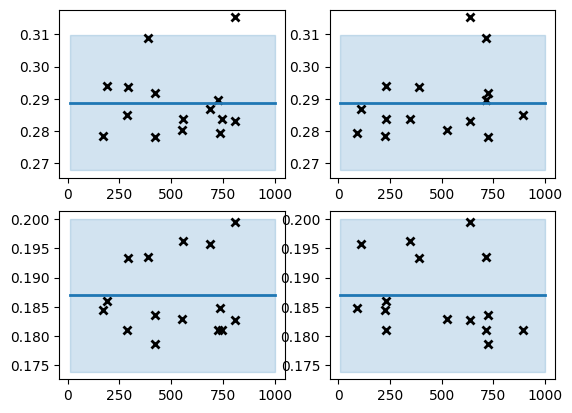

x_best =  [ 95.94932511 995.2004446 ]
acq_best =  [0.00416559 0.00260635]
C = [ 95.94932511 995.2004446 ]
Epoch 1/6
517/517 [==============================] - 3s 4ms/step - loss: 423041466368.0000 - mae: 538371.4375 - mse: 423040876544.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 2s 3ms/step - loss: 423041105920.0000 - mae: 538371.5000 - mse: 423040548864.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 423041335296.0000 - mae: 538371.4375 - mse: 423040647168.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 423041335296.0000 - mae: 538371.5000 - mse: 423040778240.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
517/517 [=======

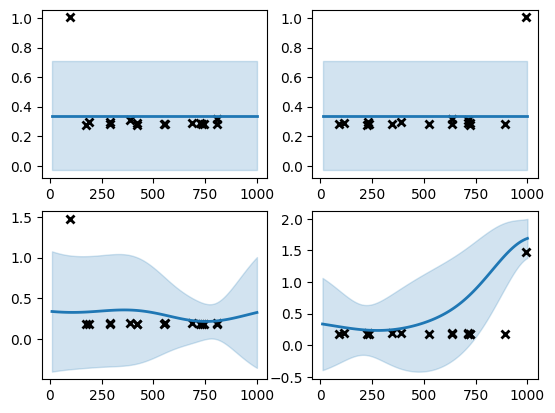

x_best =  [403.10937182 755.22096619]
acq_best =  [ 7.34498608e-02 -1.16881322e-17]
C = [403.10937182 755.22096619]
Epoch 1/6
517/517 [==============================] - 5s 7ms/step - loss: 110242439168.0000 - mae: 209360.1250 - mse: 110242201600.0000 - val_loss: 67287789568.0000 - val_mae: 185014.4531 - val_mse: 67287601152.0000
Epoch 2/6
517/517 [==============================] - 3s 5ms/step - loss: 62206144512.0000 - mae: 165601.0156 - mse: 62205988864.0000 - val_loss: 55758909440.0000 - val_mae: 156723.8594 - val_mse: 55758761984.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 59725709312.0000 - mae: 162891.2969 - mse: 59725578240.0000 - val_loss: 54835318784.0000 - val_mae: 154575.3750 - val_mse: 54835150848.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 57792004096.0000 - mae: 159642.5469 - mse: 57791848448.0000 - val_loss: 53747245056.0000 - val_mae: 153777.0312 - val_mse: 53747081216.0000
Epoch 5/6
517/517 [===========

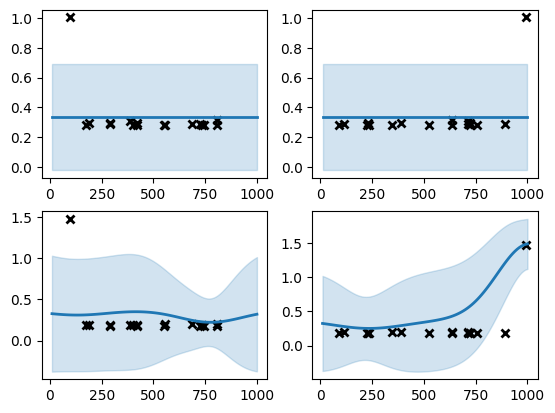

x_best =  [450.4058165 704.6337303]
acq_best =  [ 7.11952243e-02 -8.74938858e-18]
C = [450.4058165 704.6337303]
Epoch 1/6
517/517 [==============================] - 4s 6ms/step - loss: 111834161152.0000 - mae: 213028.3594 - mse: 111833915392.0000 - val_loss: 63054299136.0000 - val_mae: 165342.3438 - val_mse: 63054151680.0000
Epoch 2/6
517/517 [==============================] - 3s 6ms/step - loss: 61298741248.0000 - mae: 164671.9375 - mse: 61298540544.0000 - val_loss: 59393937408.0000 - val_mae: 172968.6562 - val_mse: 59393765376.0000
Epoch 3/6
517/517 [==============================] - 3s 7ms/step - loss: 58887888896.0000 - mae: 162345.5156 - mse: 58887700480.0000 - val_loss: 54187548672.0000 - val_mae: 158711.7812 - val_mse: 54187372544.0000
Epoch 4/6
517/517 [==============================] - 3s 5ms/step - loss: 57679167488.0000 - mae: 159821.7656 - mse: 57678962688.0000 - val_loss: 55174848512.0000 - val_mae: 159947.1562 - val_mse: 55174692864.0000
Epoch 5/6
517/517 [===============

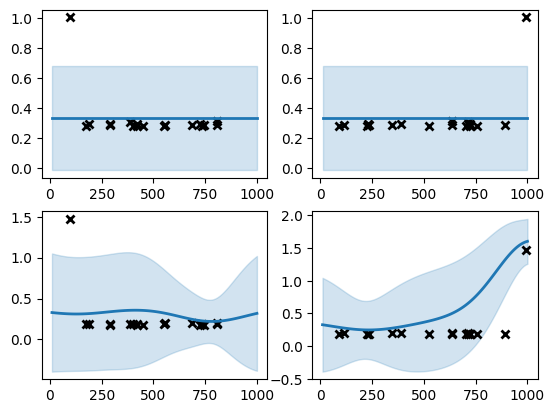

x_best =  [377.29973505 801.03546289]
acq_best =  [ 6.91392073e-02 -9.91069811e-18]
C = [377.29973505 801.03546289]
Epoch 1/6
517/517 [==============================] - 3s 4ms/step - loss: 113655693312.0000 - mae: 213271.5625 - mse: 113655463936.0000 - val_loss: 62489436160.0000 - val_mae: 158401.0625 - val_mse: 62489300992.0000
Epoch 2/6
517/517 [==============================] - 2s 5ms/step - loss: 62700191744.0000 - mae: 165585.8906 - mse: 62700027904.0000 - val_loss: 58406019072.0000 - val_mae: 154426.5781 - val_mse: 58405871616.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 58489573376.0000 - mae: 160711.3594 - mse: 58489425920.0000 - val_loss: 55462227968.0000 - val_mae: 160514.6406 - val_mse: 55462068224.0000
Epoch 4/6
517/517 [==============================] - 3s 5ms/step - loss: 58763964416.0000 - mae: 161767.4531 - mse: 58763796480.0000 - val_loss: 63129247744.0000 - val_mae: 162205.0000 - val_mse: 63129079808.0000
Epoch 5/6
517/517 [===========

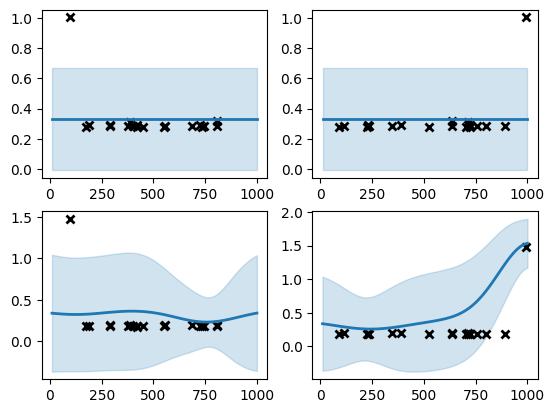

x_best =  [476.01177201 676.09723895]
acq_best =  [ 6.72288921e-02 -8.27036033e-18]
C = [476.01177201 676.09723895]
Epoch 1/6
517/517 [==============================] - 5s 8ms/step - loss: 423041138688.0000 - mae: 538371.5625 - mse: 423040679936.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 4s 7ms/step - loss: 423041105920.0000 - mae: 538371.6875 - mse: 423040614400.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 4s 7ms/step - loss: 423041105920.0000 - mae: 538371.5625 - mse: 423040614400.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 4s 7ms/step - loss: 423041269760.0000 - mae: 538371.6250 - mse: 423040745472.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
517/51

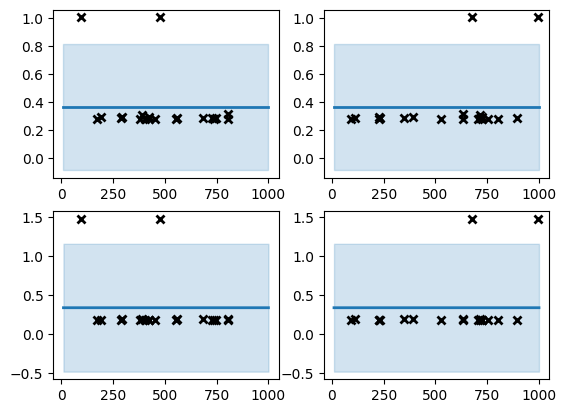

x_best =  [386.71799259 713.44906296]
acq_best =  [ 8.98891612e-02 -7.36942546e-18]
C = [386.71799259 713.44906296]
Epoch 1/6
517/517 [==============================] - 3s 5ms/step - loss: 110954954752.0000 - mae: 212657.1562 - mse: 110954692608.0000 - val_loss: 66382045184.0000 - val_mae: 182231.5312 - val_mse: 66381877248.0000
Epoch 2/6
517/517 [==============================] - 3s 6ms/step - loss: 62116536320.0000 - mae: 165216.2344 - mse: 62116384768.0000 - val_loss: 68889788416.0000 - val_mae: 169417.0781 - val_mse: 68889616384.0000
Epoch 3/6
517/517 [==============================] - 3s 6ms/step - loss: 58983342080.0000 - mae: 161025.7344 - mse: 58983206912.0000 - val_loss: 56086077440.0000 - val_mae: 152284.2500 - val_mse: 56085921792.0000
Epoch 4/6
517/517 [==============================] - 3s 5ms/step - loss: 57505800192.0000 - mae: 158517.0625 - mse: 57505656832.0000 - val_loss: 55610527744.0000 - val_mae: 158908.1875 - val_mse: 55610359808.0000
Epoch 5/6
517/517 [===========

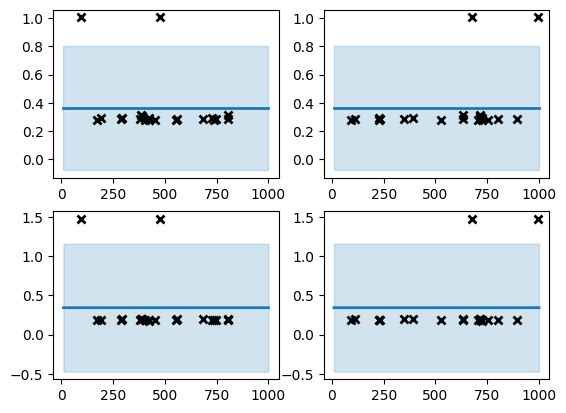

x_best =  [402.87459448 756.16737643]
acq_best =  [ 8.76158173e-02 -8.59403067e-18]
C = [402.87459448 756.16737643]
Epoch 1/6
517/517 [==============================] - 4s 6ms/step - loss: 113822203904.0000 - mae: 213830.3906 - mse: 113822031872.0000 - val_loss: 62689861632.0000 - val_mae: 162674.5156 - val_mse: 62689689600.0000
Epoch 2/6
517/517 [==============================] - 3s 6ms/step - loss: 62538870784.0000 - mae: 164351.2812 - mse: 62538690560.0000 - val_loss: 70109749248.0000 - val_mae: 168276.4688 - val_mse: 70109577216.0000
Epoch 3/6
517/517 [==============================] - 3s 7ms/step - loss: 59080790016.0000 - mae: 161455.6719 - mse: 59080605696.0000 - val_loss: 54374158336.0000 - val_mae: 152544.7500 - val_mse: 54374002688.0000
Epoch 4/6
517/517 [==============================] - 4s 7ms/step - loss: 58017624064.0000 - mae: 160585.7188 - mse: 58017460224.0000 - val_loss: 56132878336.0000 - val_mae: 154552.7031 - val_mse: 56132722688.0000
Epoch 5/6
517/517 [===========

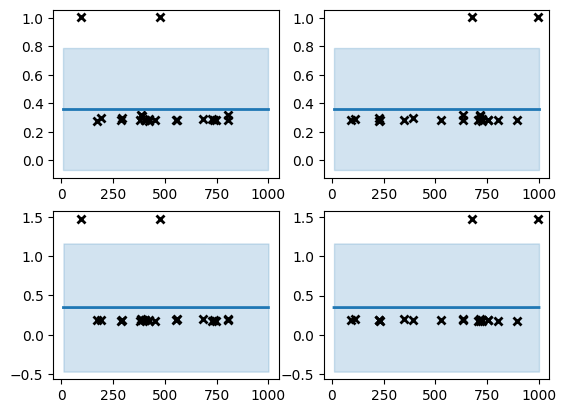

x_best =  [424.47590609 723.12577315]
acq_best =  [ 8.56715790e-02 -9.23392733e-18]
C = [424.47590609 723.12577315]
Epoch 1/6
517/517 [==============================] - 5s 6ms/step - loss: 423041335296.0000 - mae: 538371.8750 - mse: 423040974848.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 3s 6ms/step - loss: 423041138688.0000 - mae: 538371.5000 - mse: 423040516096.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 3s 6ms/step - loss: 423041269760.0000 - mae: 538371.2500 - mse: 423040745472.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 3s 6ms/step - loss: 423041236992.0000 - mae: 538371.1875 - mse: 423040516096.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
517/51

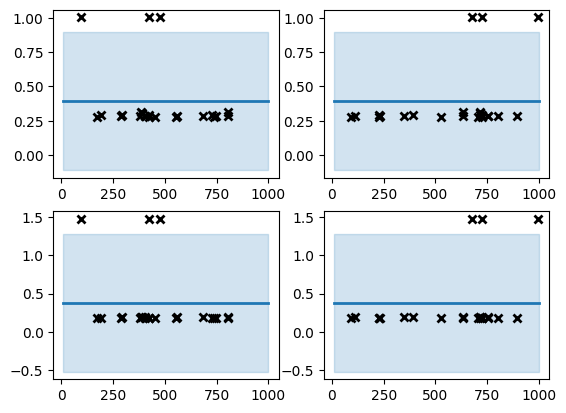

x_best =  [450.36885431 704.59354619]
acq_best =  [6.50254298e-07 5.71580607e-12]
C = [450.36885431 704.59354619]
Epoch 1/6
517/517 [==============================] - 3s 5ms/step - loss: 112705462272.0000 - mae: 211638.1406 - mse: 112705183744.0000 - val_loss: 63341109248.0000 - val_mae: 160576.6094 - val_mse: 63340957696.0000
Epoch 2/6
517/517 [==============================] - 2s 5ms/step - loss: 62388838400.0000 - mae: 164677.4219 - mse: 62388592640.0000 - val_loss: 56049520640.0000 - val_mae: 154627.2500 - val_mse: 56049360896.0000
Epoch 3/6
517/517 [==============================] - 3s 6ms/step - loss: 59022356480.0000 - mae: 161289.0000 - mse: 59022180352.0000 - val_loss: 57471664128.0000 - val_mae: 169047.7500 - val_mse: 57471504384.0000
Epoch 4/6
517/517 [==============================] - 3s 6ms/step - loss: 57925464064.0000 - mae: 160029.4375 - mse: 57925304320.0000 - val_loss: 54158647296.0000 - val_mae: 159714.1562 - val_mse: 54158508032.0000
Epoch 5/6
517/517 [=============

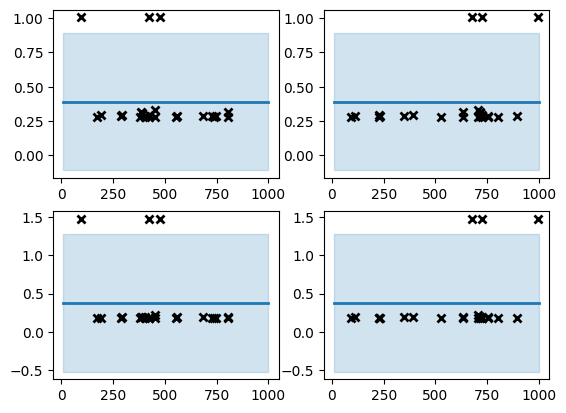

x_best =  [552.7936553  526.72445113]
acq_best =  [2.66830152e-02 1.60269889e-14]
C = [552.7936553  526.72445113]
Epoch 1/6
517/517 [==============================] - 2s 4ms/step - loss: 113224114176.0000 - mae: 211789.7344 - mse: 113223909376.0000 - val_loss: 65167564800.0000 - val_mae: 161502.2188 - val_mse: 65167409152.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 61480673280.0000 - mae: 163784.9219 - mse: 61480534016.0000 - val_loss: 55958142976.0000 - val_mae: 159240.2031 - val_mse: 55957979136.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 58666745856.0000 - mae: 161147.5781 - mse: 58666565632.0000 - val_loss: 53564649472.0000 - val_mae: 153944.4062 - val_mse: 53564510208.0000
Epoch 4/6
517/517 [==============================] - 3s 6ms/step - loss: 57503961088.0000 - mae: 159820.5000 - mse: 57503797248.0000 - val_loss: 53385838592.0000 - val_mae: 155082.6875 - val_mse: 53385670656.0000
Epoch 5/6
517/517 [=============

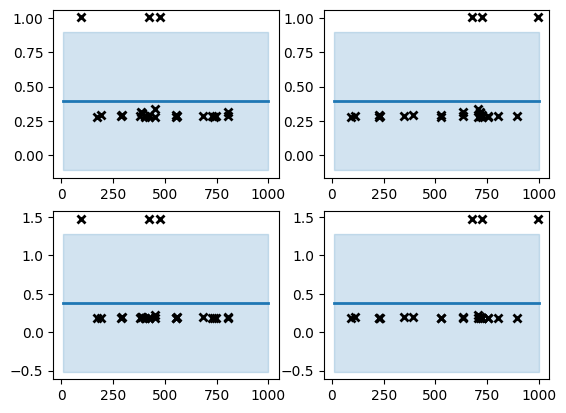

x_best =  [387.02885328 713.92491028]
acq_best =  [ 1.63217742e-05 -4.79573279e-18]
C = [387.02885328 713.92491028]
Epoch 1/6
517/517 [==============================] - 3s 5ms/step - loss: 115816816640.0000 - mae: 218256.6250 - mse: 115816603648.0000 - val_loss: 63643582464.0000 - val_mae: 170309.1875 - val_mse: 63643410432.0000
Epoch 2/6
517/517 [==============================] - 3s 5ms/step - loss: 61970153472.0000 - mae: 165485.1250 - mse: 61970006016.0000 - val_loss: 57071259648.0000 - val_mae: 155403.8750 - val_mse: 57071104000.0000
Epoch 3/6
517/517 [==============================] - 3s 6ms/step - loss: 59234545664.0000 - mae: 162081.3750 - mse: 59234385920.0000 - val_loss: 61060337664.0000 - val_mae: 158028.5938 - val_mse: 61060149248.0000
Epoch 4/6
517/517 [==============================] - 4s 7ms/step - loss: 58816999424.0000 - mae: 161354.1406 - mse: 58816843776.0000 - val_loss: 57427787776.0000 - val_mae: 154199.8281 - val_mse: 57427636224.0000
Epoch 5/6
517/517 [===========

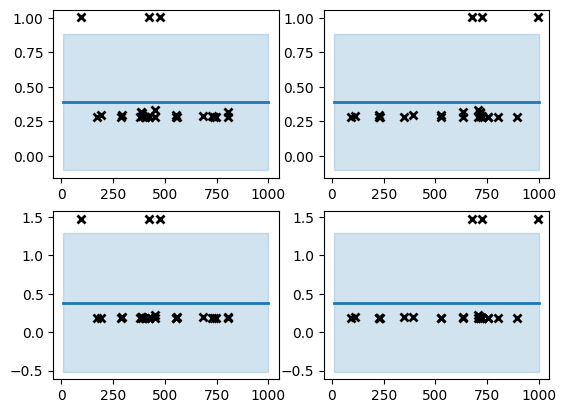

x_best =  [557.72178866 347.00946075]
acq_best =  [1.27644303e-18 3.15403796e-49]
C = [557.72178866 347.00946075]
Epoch 1/6
517/517 [==============================] - 2s 3ms/step - loss: 112083566592.0000 - mae: 212670.9531 - mse: 112083419136.0000 - val_loss: 63312510976.0000 - val_mae: 163445.0312 - val_mse: 63312343040.0000
Epoch 2/6
517/517 [==============================] - 1s 3ms/step - loss: 60952662016.0000 - mae: 162986.2656 - mse: 60952518656.0000 - val_loss: 54989238272.0000 - val_mae: 159706.7188 - val_mse: 54989078528.0000
Epoch 3/6
517/517 [==============================] - 2s 3ms/step - loss: 57697386496.0000 - mae: 159322.2031 - mse: 57697206272.0000 - val_loss: 56537096192.0000 - val_mae: 156492.4688 - val_mse: 56536956928.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 57890713600.0000 - mae: 159946.8906 - mse: 57890562048.0000 - val_loss: 53564874752.0000 - val_mae: 151974.7344 - val_mse: 53564723200.0000
Epoch 5/6
517/517 [=============

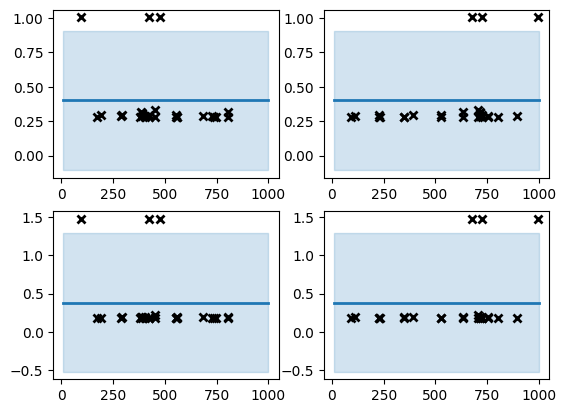

x_best =  [288.83504366 892.18812624]
acq_best =  [ 1.13653136e-07 -7.42858154e-18]
C = [288.83504366 892.18812624]
Epoch 1/6
517/517 [==============================] - 4s 6ms/step - loss: 118156025856.0000 - mae: 216682.3594 - mse: 118155755520.0000 - val_loss: 69479202816.0000 - val_mae: 164954.2344 - val_mse: 69479014400.0000
Epoch 2/6
517/517 [==============================] - 3s 6ms/step - loss: 63492825088.0000 - mae: 165497.9531 - mse: 63492661248.0000 - val_loss: 57754427392.0000 - val_mae: 167351.9688 - val_mse: 57754230784.0000
Epoch 3/6
517/517 [==============================] - 3s 6ms/step - loss: 60825391104.0000 - mae: 163230.4688 - mse: 60825235456.0000 - val_loss: 54266322944.0000 - val_mae: 152358.7812 - val_mse: 54266171392.0000
Epoch 4/6
517/517 [==============================] - 3s 6ms/step - loss: 57748643840.0000 - mae: 158396.9062 - mse: 57748496384.0000 - val_loss: 54642024448.0000 - val_mae: 156666.2969 - val_mse: 54641868800.0000
Epoch 5/6
517/517 [===========

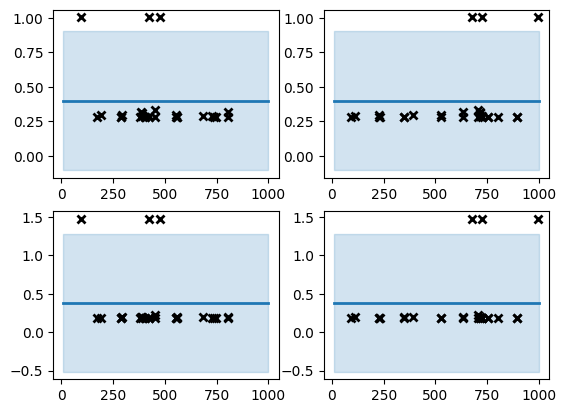

x_best =  [557.71091071 347.05513479]
acq_best =  [ 7.83954282e-09 -1.08605165e-17]
C = [557.71091071 347.05513479]
Epoch 1/6
517/517 [==============================] - 5s 7ms/step - loss: 114795028480.0000 - mae: 213281.8750 - mse: 114794823680.0000 - val_loss: 63620972544.0000 - val_mae: 167426.2188 - val_mse: 63620816896.0000
Epoch 2/6
517/517 [==============================] - 3s 5ms/step - loss: 62583705600.0000 - mae: 165068.1562 - mse: 62583521280.0000 - val_loss: 58568404992.0000 - val_mae: 158178.4688 - val_mse: 58568261632.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 58628100096.0000 - mae: 160979.7500 - mse: 58627919872.0000 - val_loss: 60881907712.0000 - val_mae: 156961.8281 - val_mse: 60881752064.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 57900896256.0000 - mae: 159804.7344 - mse: 57900756992.0000 - val_loss: 55082971136.0000 - val_mae: 152470.0938 - val_mse: 55082803200.0000
Epoch 5/6
517/517 [===========

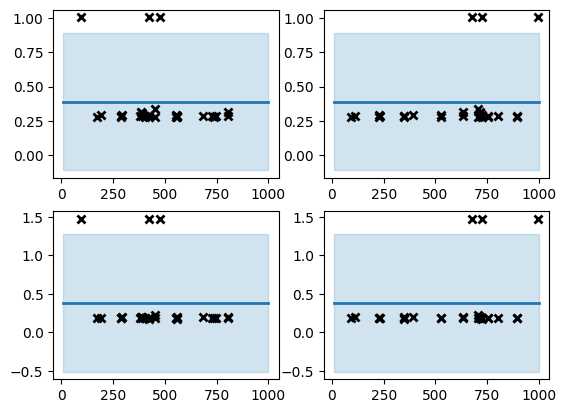

x_best =  [746.44093981 232.38140413]
acq_best =  [1.71594222e-08 1.15530122e-47]
C = [746.44093981 232.38140413]
Epoch 1/6
517/517 [==============================] - 4s 5ms/step - loss: 112427130880.0000 - mae: 210610.7344 - mse: 112426893312.0000 - val_loss: 64467259392.0000 - val_mae: 169872.9375 - val_mse: 64467107840.0000
Epoch 2/6
517/517 [==============================] - 3s 5ms/step - loss: 63145648128.0000 - mae: 165699.9688 - mse: 63145443328.0000 - val_loss: 55444967424.0000 - val_mae: 155542.8281 - val_mse: 55444799488.0000
Epoch 3/6
517/517 [==============================] - 3s 5ms/step - loss: 59216773120.0000 - mae: 161984.5312 - mse: 59216621568.0000 - val_loss: 53959200768.0000 - val_mae: 156576.1562 - val_mse: 53959073792.0000
Epoch 4/6
517/517 [==============================] - 2s 5ms/step - loss: 58507554816.0000 - mae: 161593.9688 - mse: 58507366400.0000 - val_loss: 53866835968.0000 - val_mae: 154014.7188 - val_mse: 53866668032.0000
Epoch 5/6
517/517 [=============

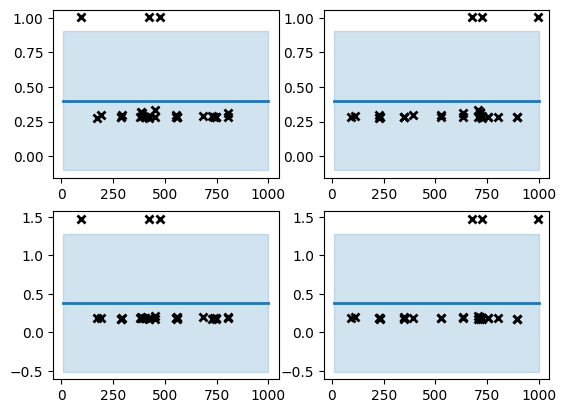

x_best =  [377.30592899 801.0308171 ]
acq_best =  [3.90336621e-14 3.48787491e-57]
C = [377.30592899 801.0308171 ]
Epoch 1/6
517/517 [==============================] - 4s 6ms/step - loss: 423041073152.0000 - mae: 538371.3125 - mse: 423040548864.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 3s 6ms/step - loss: 423041105920.0000 - mae: 538371.3750 - mse: 423040581632.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 3s 6ms/step - loss: 423041368064.0000 - mae: 538371.5000 - mse: 423040712704.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 4s 7ms/step - loss: 423041400832.0000 - mae: 538371.3125 - mse: 423040778240.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
517/517 

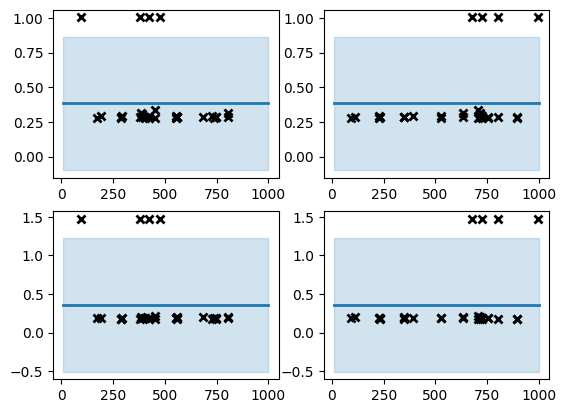

x_best =  [286.35203893 207.31134496]
acq_best =  [0.09601588 0.17260154]
C = [286.35203893 207.31134496]
Epoch 1/6
517/517 [==============================] - 2s 2ms/step - loss: 130818801664.0000 - mae: 230572.2031 - mse: 130818555904.0000 - val_loss: 92756279296.0000 - val_mae: 190017.1562 - val_mse: 92756090880.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 68562886656.0000 - mae: 169084.7031 - mse: 68562747392.0000 - val_loss: 55991455744.0000 - val_mae: 156263.0781 - val_mse: 55991308288.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 59175546880.0000 - mae: 161261.7812 - mse: 59175399424.0000 - val_loss: 54810935296.0000 - val_mae: 153415.3125 - val_mse: 54810750976.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 57534976000.0000 - mae: 159193.7031 - mse: 57534844928.0000 - val_loss: 54784131072.0000 - val_mae: 152532.3594 - val_mse: 54783979520.0000
Epoch 5/6
517/517 [=====================

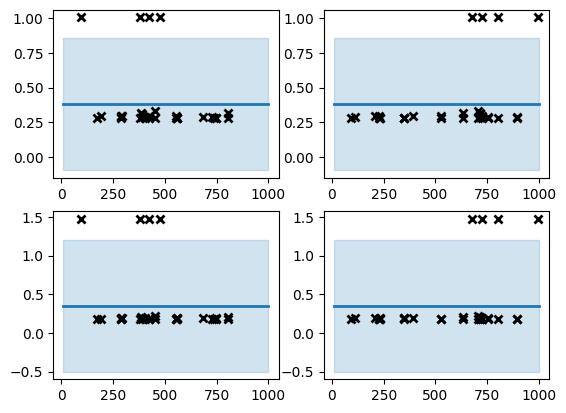

x_best =  [514.54786068  23.65128723]
acq_best =  [0.09467655 0.17020742]
C = [514.54786068  23.65128723]
Epoch 1/6
517/517 [==============================] - 3s 4ms/step - loss: 140151259136.0000 - mae: 238614.7344 - mse: 140151046144.0000 - val_loss: 108889382912.0000 - val_mae: 202403.5312 - val_mse: 108889153536.0000
Epoch 2/6
517/517 [==============================] - 2s 3ms/step - loss: 82860425216.0000 - mae: 180897.9062 - mse: 82860220416.0000 - val_loss: 65411842048.0000 - val_mae: 161371.6406 - val_mse: 65411706880.0000
Epoch 3/6
517/517 [==============================] - 2s 3ms/step - loss: 62757478400.0000 - mae: 163296.0000 - mse: 62757310464.0000 - val_loss: 58001993728.0000 - val_mae: 156966.5938 - val_mse: 58001829888.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 60506509312.0000 - mae: 162333.8281 - mse: 60506353664.0000 - val_loss: 56534728704.0000 - val_mae: 154988.1875 - val_mse: 56534593536.0000
Epoch 5/6
517/517 [===================

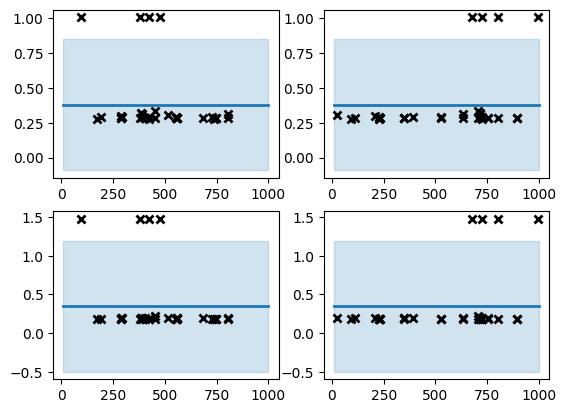

x_best =  [974.63327555 368.76176492]
acq_best =  [0.09336142 0.16797391]
C = [974.63327555 368.76176492]
Epoch 1/6
517/517 [==============================] - 6s 8ms/step - loss: 103475634176.0000 - mae: 205687.5938 - mse: 103475478528.0000 - val_loss: 61051535360.0000 - val_mae: 170134.6719 - val_mse: 61051387904.0000
Epoch 2/6
517/517 [==============================] - 4s 9ms/step - loss: 60706521088.0000 - mae: 163198.1406 - mse: 60706369536.0000 - val_loss: 54593814528.0000 - val_mae: 153242.6875 - val_mse: 54593662976.0000
Epoch 3/6
517/517 [==============================] - 5s 9ms/step - loss: 58683994112.0000 - mae: 160560.2344 - mse: 58683809792.0000 - val_loss: 54709321728.0000 - val_mae: 151711.0781 - val_mse: 54709161984.0000
Epoch 4/6
517/517 [==============================] - 4s 8ms/step - loss: 57297440768.0000 - mae: 159001.5938 - mse: 57297268736.0000 - val_loss: 52995252224.0000 - val_mae: 155290.7656 - val_mse: 52995096576.0000
Epoch 5/6
517/517 [=====================

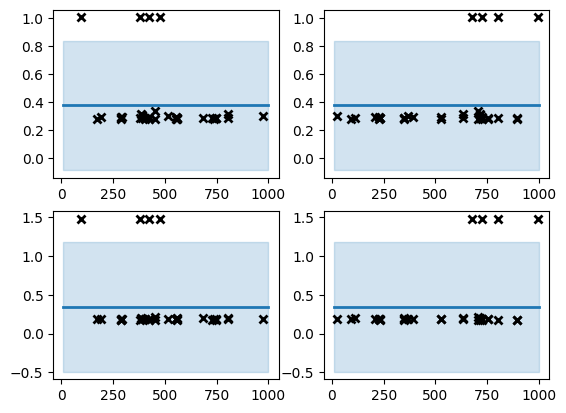

x_best =  [687.59091809 830.92644163]
acq_best =  [0.09211242 0.16578439]
C = [687.59091809 830.92644163]
Epoch 1/6
517/517 [==============================] - 5s 8ms/step - loss: 105060540416.0000 - mae: 205850.0000 - mse: 105060311040.0000 - val_loss: 57941970944.0000 - val_mae: 157023.5156 - val_mse: 57941815296.0000
Epoch 2/6
517/517 [==============================] - 4s 7ms/step - loss: 60960059392.0000 - mae: 163838.4531 - mse: 60959911936.0000 - val_loss: 61817192448.0000 - val_mae: 166758.8594 - val_mse: 61817036800.0000
Epoch 3/6
517/517 [==============================] - 3s 6ms/step - loss: 59839873024.0000 - mae: 163053.9375 - mse: 59839741952.0000 - val_loss: 54215745536.0000 - val_mae: 155913.1094 - val_mse: 54215589888.0000
Epoch 4/6
517/517 [==============================] - 4s 8ms/step - loss: 57715499008.0000 - mae: 160266.1719 - mse: 57715339264.0000 - val_loss: 55378018304.0000 - val_mae: 160829.2969 - val_mse: 55377870848.0000
Epoch 5/6
517/517 [=====================

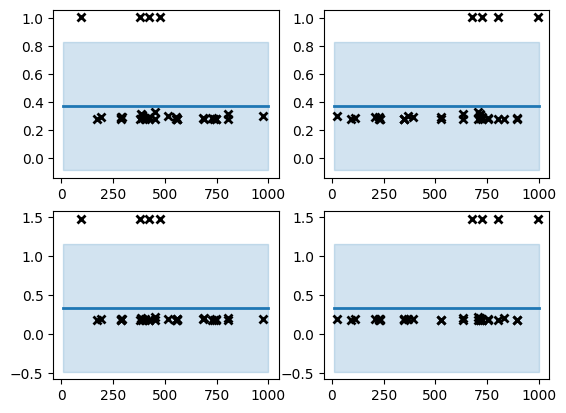

x_best =  [ 93.26807057 838.48928088]
acq_best =  [0.09097807 0.16360568]
C = [ 93.26807057 838.48928088]
Epoch 1/6
517/517 [==============================] - 4s 5ms/step - loss: 423041564672.0000 - mae: 538371.5000 - mse: 423040942080.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 423041204224.0000 - mae: 538371.3750 - mse: 423040778240.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 2s 3ms/step - loss: 423041269760.0000 - mae: 538371.5000 - mse: 423040778240.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 423040909312.0000 - mae: 538371.6875 - mse: 423040450560.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
517/517 [=======

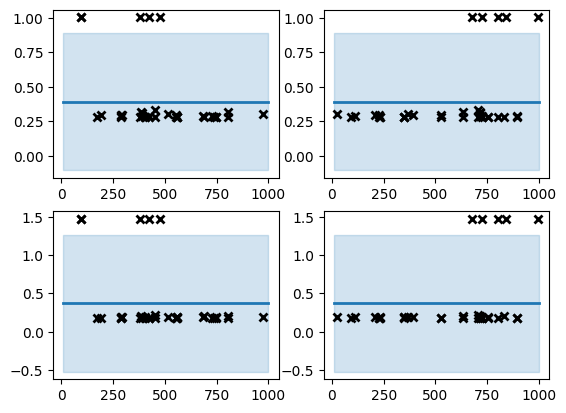

x_best =  [130.51723275 917.45514347]
acq_best =  [0.09889925 0.17789227]
C = [130.51723275 917.45514347]
Epoch 1/6
517/517 [==============================] - 2s 3ms/step - loss: 127656378368.0000 - mae: 227173.7500 - mse: 127656189952.0000 - val_loss: 94633361408.0000 - val_mae: 211581.8438 - val_mse: 94633107456.0000
Epoch 2/6
517/517 [==============================] - 1s 3ms/step - loss: 69024202752.0000 - mae: 169095.2031 - mse: 69024006144.0000 - val_loss: 56848474112.0000 - val_mae: 161469.7812 - val_mse: 56848338944.0000
Epoch 3/6
517/517 [==============================] - 1s 3ms/step - loss: 59964788736.0000 - mae: 162836.2031 - mse: 59964624896.0000 - val_loss: 56476168192.0000 - val_mae: 153725.5469 - val_mse: 56476020736.0000
Epoch 4/6
517/517 [==============================] - 1s 3ms/step - loss: 58622619648.0000 - mae: 161229.0469 - mse: 58622488576.0000 - val_loss: 54719549440.0000 - val_mae: 154023.9688 - val_mse: 54719397888.0000
Epoch 5/6
517/517 [=====================

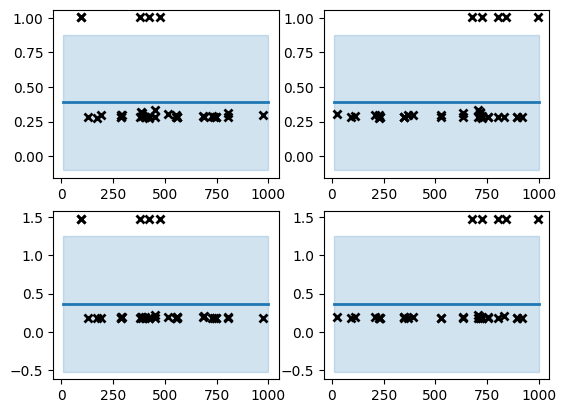

x_best =  [418.11555796 116.06509637]
acq_best =  [0.09778755 0.17585739]
C = [418.11555796 116.06509637]
Epoch 1/6
517/517 [==============================] - 2s 2ms/step - loss: 132239900672.0000 - mae: 231162.8438 - mse: 132239679488.0000 - val_loss: 101949808640.0000 - val_mae: 220399.3750 - val_mse: 101949620224.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 73016221696.0000 - mae: 171985.2500 - mse: 73016066048.0000 - val_loss: 57906331648.0000 - val_mae: 158592.1250 - val_mse: 57906171904.0000
Epoch 3/6
517/517 [==============================] - 2s 3ms/step - loss: 60331110400.0000 - mae: 162436.7188 - mse: 60330934272.0000 - val_loss: 57221632000.0000 - val_mae: 155615.4375 - val_mse: 57221472256.0000
Epoch 4/6
517/517 [==============================] - 1s 3ms/step - loss: 58830692352.0000 - mae: 160777.1406 - mse: 58830528512.0000 - val_loss: 54745665536.0000 - val_mae: 155833.9375 - val_mse: 54745518080.0000
Epoch 5/6
517/517 [===================

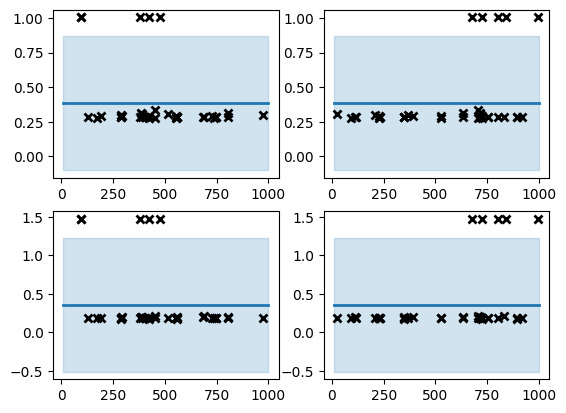

x_best =  [121.98028245 513.29316227]
acq_best =  [0.09668945 0.17386765]
C = [121.98028245 513.29316227]
Epoch 1/6
517/517 [==============================] - 3s 3ms/step - loss: 423041236992.0000 - mae: 538371.5000 - mse: 423040647168.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 1s 3ms/step - loss: 423041171456.0000 - mae: 538371.5000 - mse: 423040581632.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 2s 3ms/step - loss: 423041040384.0000 - mae: 538371.6250 - mse: 423040647168.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 1s 3ms/step - loss: 423041236992.0000 - mae: 538371.1875 - mse: 423040581632.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
517/517 [=======

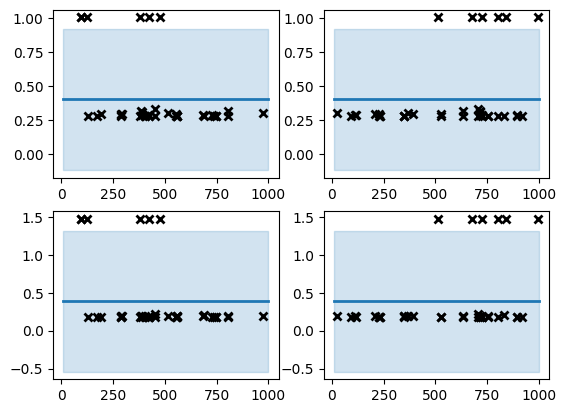

x_best =  [170.89669264  98.14673651]
acq_best =  [0.10321569 0.18565503]
C = [170.89669264  98.14673651]
Epoch 1/6
517/517 [==============================] - 3s 3ms/step - loss: 137569419264.0000 - mae: 237920.2188 - mse: 137569091584.0000 - val_loss: 113487495168.0000 - val_mae: 208094.1719 - val_mse: 113487323136.0000
Epoch 2/6
517/517 [==============================] - 1s 3ms/step - loss: 85348663296.0000 - mae: 183348.8750 - mse: 85348450304.0000 - val_loss: 61850435584.0000 - val_mae: 162367.8594 - val_mse: 61850271744.0000
Epoch 3/6
517/517 [==============================] - 1s 3ms/step - loss: 62657908736.0000 - mae: 163416.9062 - mse: 62657761280.0000 - val_loss: 56835899392.0000 - val_mae: 154887.2188 - val_mse: 56835715072.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 60864483328.0000 - mae: 162024.2656 - mse: 60864360448.0000 - val_loss: 55392903168.0000 - val_mae: 153985.1406 - val_mse: 55392759808.0000
Epoch 5/6
517/517 [===================

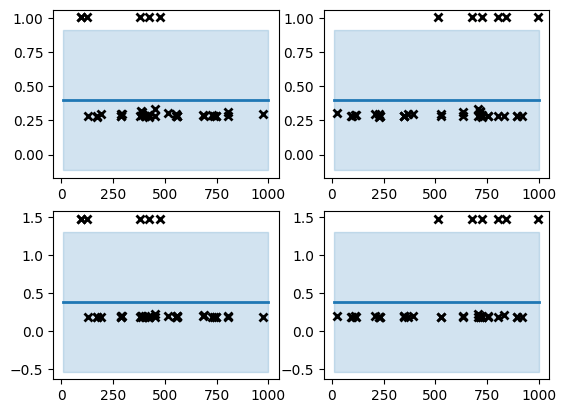

x_best =  [793.54482749 583.42474918]
acq_best =  [0.10216613 0.18370965]
C = [793.54482749 583.42474918]
Epoch 1/6
517/517 [==============================] - 5s 8ms/step - loss: 104655192064.0000 - mae: 207138.3906 - mse: 104654970880.0000 - val_loss: 68318150656.0000 - val_mae: 166884.3125 - val_mse: 68317974528.0000
Epoch 2/6
517/517 [==============================] - 4s 8ms/step - loss: 60896215040.0000 - mae: 163846.4844 - mse: 60896071680.0000 - val_loss: 57689993216.0000 - val_mae: 166047.6875 - val_mse: 57689825280.0000
Epoch 3/6
517/517 [==============================] - 4s 7ms/step - loss: 58390695936.0000 - mae: 160466.2812 - mse: 58390536192.0000 - val_loss: 55309238272.0000 - val_mae: 152228.0781 - val_mse: 55309086720.0000
Epoch 4/6
517/517 [==============================] - 3s 6ms/step - loss: 57238548480.0000 - mae: 158794.6875 - mse: 57238376448.0000 - val_loss: 55230341120.0000 - val_mae: 151272.2812 - val_mse: 55230193664.0000
Epoch 5/6
517/517 [=====================

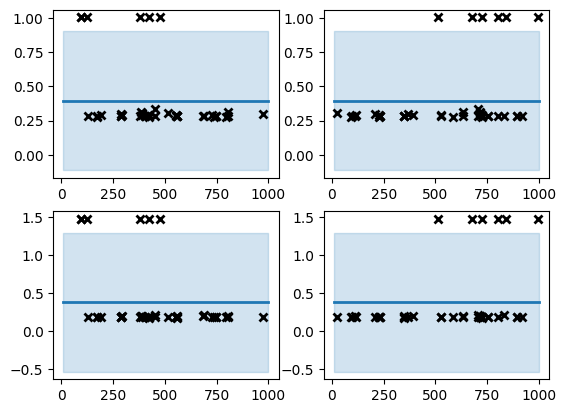

x_best =  [974.5615913  291.04178615]
acq_best =  [0.10116934 0.1818426 ]
C = [974.5615913  291.04178615]
Epoch 1/6
517/517 [==============================] - 4s 5ms/step - loss: 103898406912.0000 - mae: 204549.6562 - mse: 103898243072.0000 - val_loss: 57542692864.0000 - val_mae: 156059.1719 - val_mse: 57542537216.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 60844191744.0000 - mae: 163919.7188 - mse: 60844036096.0000 - val_loss: 55747366912.0000 - val_mae: 154570.8750 - val_mse: 55747215360.0000
Epoch 3/6
517/517 [==============================] - 3s 6ms/step - loss: 58594103296.0000 - mae: 160537.5156 - mse: 58593964032.0000 - val_loss: 55144558592.0000 - val_mae: 155372.1250 - val_mse: 55144386560.0000
Epoch 4/6
517/517 [==============================] - 3s 6ms/step - loss: 57632235520.0000 - mae: 159794.9375 - mse: 57632083968.0000 - val_loss: 53862567936.0000 - val_mae: 157849.9219 - val_mse: 53862428672.0000
Epoch 5/6
517/517 [=====================

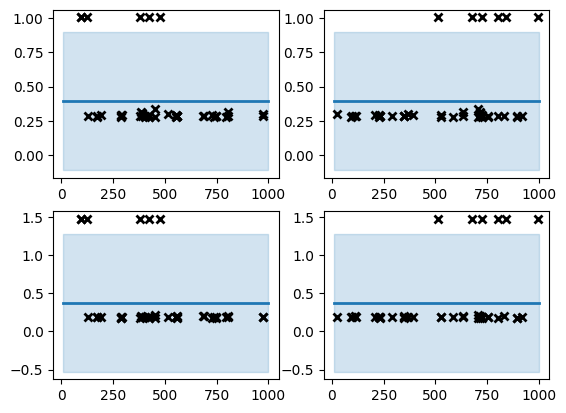

x_best =  [667.52865434 993.43397857]
acq_best =  [0.10016605 0.18001429]
C = [667.52865434 993.43397857]
Epoch 1/6
517/517 [==============================] - 7s 12ms/step - loss: 98649292800.0000 - mae: 201929.2031 - mse: 98649096192.0000 - val_loss: 63631507456.0000 - val_mae: 176882.8438 - val_mse: 63631351808.0000
Epoch 2/6
517/517 [==============================] - 6s 12ms/step - loss: 59504664576.0000 - mae: 162611.9375 - mse: 59504517120.0000 - val_loss: 60913389568.0000 - val_mae: 171120.0469 - val_mse: 60913229824.0000
Epoch 3/6
517/517 [==============================] - 5s 10ms/step - loss: 57605619712.0000 - mae: 159923.4844 - mse: 57605443584.0000 - val_loss: 56969375744.0000 - val_mae: 153418.0312 - val_mse: 56969216000.0000
Epoch 4/6
517/517 [==============================] - 7s 13ms/step - loss: 57353695232.0000 - mae: 158937.7031 - mse: 57353531392.0000 - val_loss: 54875226112.0000 - val_mae: 151612.1719 - val_mse: 54875078656.0000
Epoch 5/6
517/517 [===================

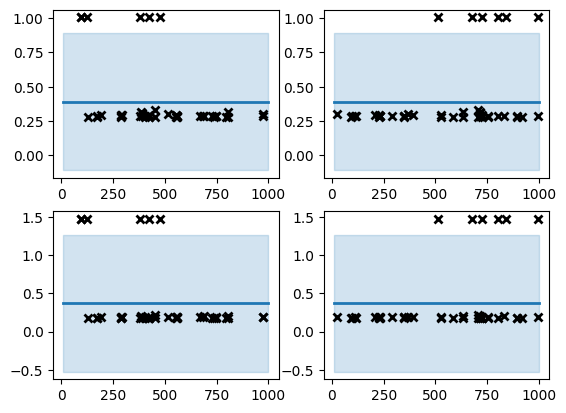

x_best =  [395.32780281 518.23967622]
acq_best =  [0.09918361 0.17820471]
C = [395.32780281 518.23967622]
Epoch 1/6
517/517 [==============================] - 4s 6ms/step - loss: 423041531904.0000 - mae: 538371.4375 - mse: 423040974848.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 3s 6ms/step - loss: 423041368064.0000 - mae: 538371.5625 - mse: 423040876544.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 2s 5ms/step - loss: 423041302528.0000 - mae: 538371.5000 - mse: 423040909312.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 423041335296.0000 - mae: 538371.4375 - mse: 423040942080.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
517/517 [=======

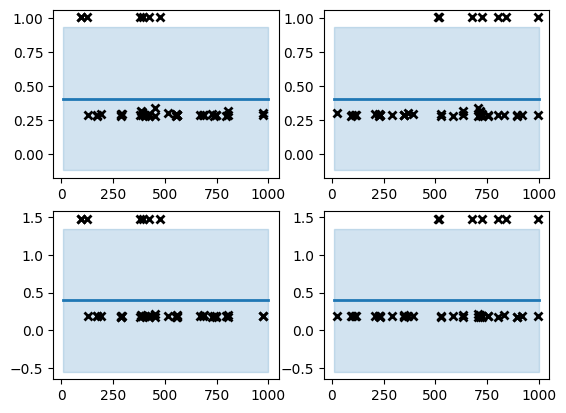

x_best =  [965.0261265   29.79166089]
acq_best =  [0.10470618 0.18816942]
C = [965.0261265   29.79166089]
Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 423041073152.0000 - mae: 538371.8125 - mse: 423040614400.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 1s 1ms/step - loss: 423041236992.0000 - mae: 538371.2500 - mse: 423040712704.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 1s 1ms/step - loss: 423041204224.0000 - mae: 538371.6250 - mse: 423040614400.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 1s 1ms/step - loss: 423041138688.0000 - mae: 538371.4375 - mse: 423040745472.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
517/517 [=======

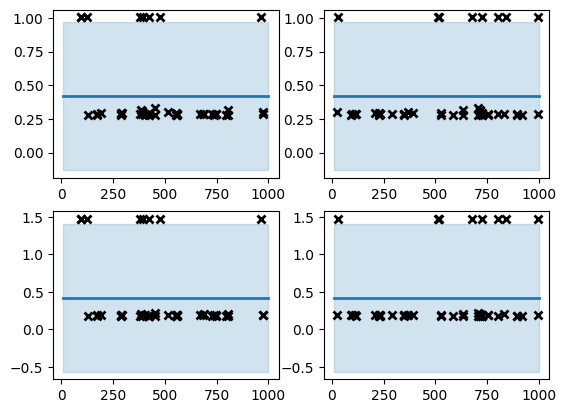

x_best =  [549.04315646 399.28809293]
acq_best =  [0.10946846 0.19673375]
C = [549.04315646 399.28809293]
Epoch 1/6
517/517 [==============================] - 3s 4ms/step - loss: 113923481600.0000 - mae: 214175.5312 - mse: 113923260416.0000 - val_loss: 65909354496.0000 - val_mae: 175473.3438 - val_mse: 65909178368.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 62497488896.0000 - mae: 164256.7969 - mse: 62497337344.0000 - val_loss: 56143101952.0000 - val_mae: 154214.4531 - val_mse: 56142929920.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 58175602688.0000 - mae: 160436.0938 - mse: 58175442944.0000 - val_loss: 56426651648.0000 - val_mae: 151638.0625 - val_mse: 56426504192.0000
Epoch 4/6
517/517 [==============================] - 1s 3ms/step - loss: 57160572928.0000 - mae: 158892.5781 - mse: 57160380416.0000 - val_loss: 55196225536.0000 - val_mae: 152216.6250 - val_mse: 55196069888.0000
Epoch 5/6
517/517 [=====================

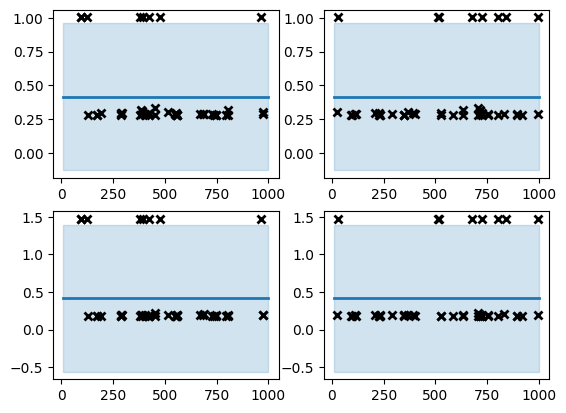

x_best =  [635.01752368 933.20553033]
acq_best =  [0.10853384 0.19505366]
C = [635.01752368 933.20553033]
Epoch 1/6
517/517 [==============================] - 7s 12ms/step - loss: 109484244992.0000 - mae: 208107.7969 - mse: 109484048384.0000 - val_loss: 59406512128.0000 - val_mae: 162070.4531 - val_mse: 59406385152.0000
Epoch 2/6
517/517 [==============================] - 8s 15ms/step - loss: 61061074944.0000 - mae: 164354.5156 - mse: 61060902912.0000 - val_loss: 58815496192.0000 - val_mae: 156526.9531 - val_mse: 58815352832.0000
Epoch 3/6
517/517 [==============================] - 7s 14ms/step - loss: 58476916736.0000 - mae: 160207.5000 - mse: 58476748800.0000 - val_loss: 60817780736.0000 - val_mae: 160169.8906 - val_mse: 60817604608.0000
Epoch 4/6
517/517 [==============================] - 6s 11ms/step - loss: 57741537280.0000 - mae: 159323.7812 - mse: 57741385728.0000 - val_loss: 55512674304.0000 - val_mae: 150785.3281 - val_mse: 55512530944.0000
Epoch 5/6
517/517 [=================

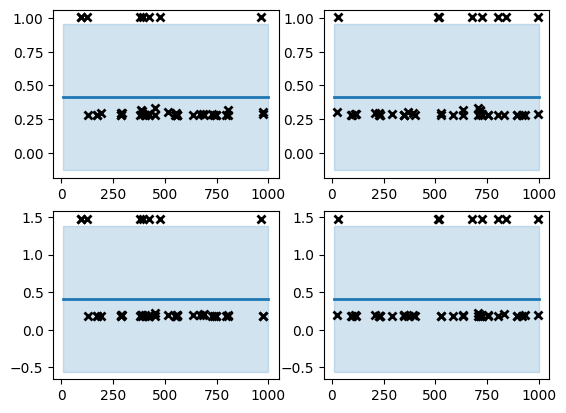

x_best =  [ 95.61911999 706.19279219]
acq_best =  [0.10763912 0.1933531 ]
C = [ 95.61911999 706.19279219]
Epoch 1/6
517/517 [==============================] - 2s 2ms/step - loss: 127342354432.0000 - mae: 226087.2656 - mse: 127342100480.0000 - val_loss: 90337746944.0000 - val_mae: 199387.4844 - val_mse: 90337542144.0000
Epoch 2/6
517/517 [==============================] - 1s 1ms/step - loss: 69202911232.0000 - mae: 169423.1094 - mse: 69202739200.0000 - val_loss: 56498196480.0000 - val_mae: 157456.6094 - val_mse: 56498044928.0000
Epoch 3/6
517/517 [==============================] - 1s 1ms/step - loss: 60520263680.0000 - mae: 163010.0625 - mse: 60520103936.0000 - val_loss: 55126966272.0000 - val_mae: 157156.3906 - val_mse: 55126798336.0000
Epoch 4/6
517/517 [==============================] - 1s 1ms/step - loss: 59527385088.0000 - mae: 162403.9531 - mse: 59527225344.0000 - val_loss: 54395052032.0000 - val_mae: 156521.1719 - val_mse: 54394884096.0000
Epoch 5/6
517/517 [=====================

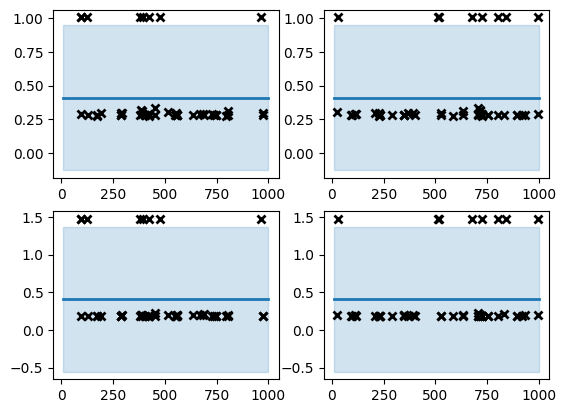

x_best =  [775.31351854 198.12893172]
acq_best =  [0.10672508 0.19173062]
C = [775.31351854 198.12893172]
Epoch 1/6
517/517 [==============================] - 4s 5ms/step - loss: 118942547968.0000 - mae: 218005.7188 - mse: 118942351360.0000 - val_loss: 73800302592.0000 - val_mae: 169679.8125 - val_mse: 73800097792.0000
Epoch 2/6
517/517 [==============================] - 3s 5ms/step - loss: 63387435008.0000 - mae: 165309.8594 - mse: 63387295744.0000 - val_loss: 64828362752.0000 - val_mae: 162437.9688 - val_mse: 64828186624.0000
Epoch 3/6
517/517 [==============================] - 3s 5ms/step - loss: 59367067648.0000 - mae: 161863.6719 - mse: 59366871040.0000 - val_loss: 54465351680.0000 - val_mae: 157619.9531 - val_mse: 54465191936.0000
Epoch 4/6
517/517 [==============================] - 3s 5ms/step - loss: 57717190656.0000 - mae: 160131.2969 - mse: 57717022720.0000 - val_loss: 54377349120.0000 - val_mae: 160423.8281 - val_mse: 54377181184.0000
Epoch 5/6
517/517 [=====================

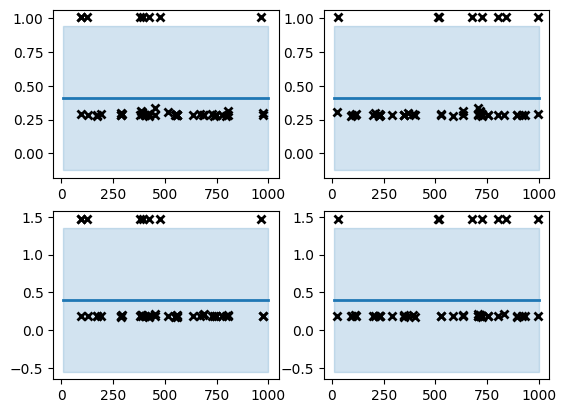

x_best =  [405.73440602 377.43852369]
acq_best =  [0.10585881 0.190127  ]
C = [405.73440602 377.43852369]
Epoch 1/6
517/517 [==============================] - 3s 4ms/step - loss: 423041007616.0000 - mae: 538371.6250 - mse: 423040516096.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 423041302528.0000 - mae: 538371.1250 - mse: 423040876544.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 423041433600.0000 - mae: 538371.3750 - mse: 423040778240.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 423040843776.0000 - mae: 538371.6875 - mse: 423040450560.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
517/517 [=======

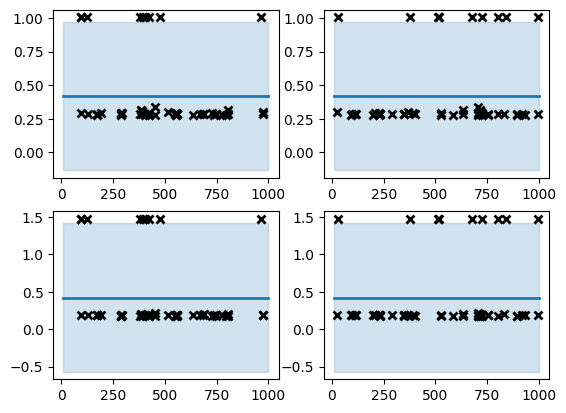

x_best =  [275.97462735  29.71883345]
acq_best =  [0.11005126 0.19767703]
C = [275.97462735  29.71883345]
Epoch 1/6
517/517 [==============================] - 3s 3ms/step - loss: 139403722752.0000 - mae: 238913.2969 - mse: 139403509760.0000 - val_loss: 108799000576.0000 - val_mae: 207157.3594 - val_mse: 108798844928.0000
Epoch 2/6
517/517 [==============================] - 1s 3ms/step - loss: 84665065472.0000 - mae: 181535.6250 - mse: 84664893440.0000 - val_loss: 63350898688.0000 - val_mae: 167099.7969 - val_mse: 63350734848.0000
Epoch 3/6
517/517 [==============================] - 2s 3ms/step - loss: 62824820736.0000 - mae: 164158.5000 - mse: 62824644608.0000 - val_loss: 57300574208.0000 - val_mae: 159977.2656 - val_mse: 57300443136.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 60190183424.0000 - mae: 161660.4375 - mse: 60190023680.0000 - val_loss: 57160683520.0000 - val_mae: 155649.3281 - val_mse: 57160540160.0000
Epoch 5/6
517/517 [===================

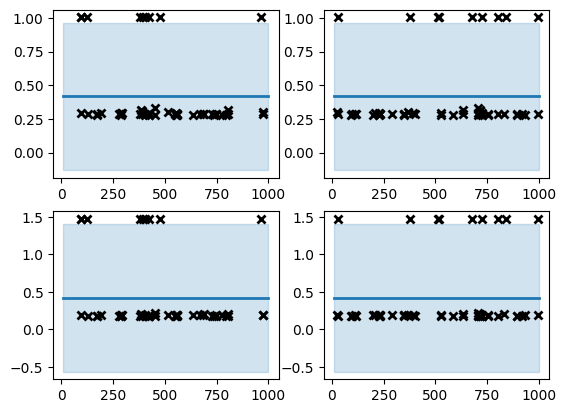

x_best =  [829.08081213 965.61204702]
acq_best =  [0.10920315 0.19615114]
C = [829.08081213 965.61204702]
Epoch 1/6
517/517 [==============================] - 5s 8ms/step - loss: 101272756224.0000 - mae: 203312.6562 - mse: 101272576000.0000 - val_loss: 58323558400.0000 - val_mae: 167159.7500 - val_mse: 58323382272.0000
Epoch 2/6
517/517 [==============================] - 6s 11ms/step - loss: 60030558208.0000 - mae: 163368.4219 - mse: 60030414848.0000 - val_loss: 53746077696.0000 - val_mae: 157575.3750 - val_mse: 53745926144.0000
Epoch 3/6
517/517 [==============================] - 7s 13ms/step - loss: 57961619456.0000 - mae: 159962.9844 - mse: 57961484288.0000 - val_loss: 54294286336.0000 - val_mae: 152190.8438 - val_mse: 54294114304.0000
Epoch 4/6
517/517 [==============================] - 7s 14ms/step - loss: 57108152320.0000 - mae: 158545.0312 - mse: 57107976192.0000 - val_loss: 53588099072.0000 - val_mae: 157049.1406 - val_mse: 53587951616.0000
Epoch 5/6
517/517 [==================

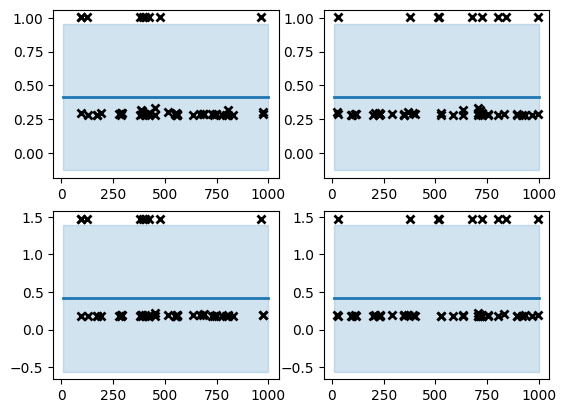

x_best =  [199.17272288 671.03358537]
acq_best =  [0.10839429 0.19466762]
C = [199.17272288 671.03358537]
Epoch 1/6
517/517 [==============================] - 4s 5ms/step - loss: 423041204224.0000 - mae: 538371.6875 - mse: 423040581632.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 423041302528.0000 - mae: 538371.3750 - mse: 423040778240.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 2s 5ms/step - loss: 423041138688.0000 - mae: 538371.6250 - mse: 423040614400.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 2s 5ms/step - loss: 423041302528.0000 - mae: 538371.5625 - mse: 423040811008.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
517/517 [=======

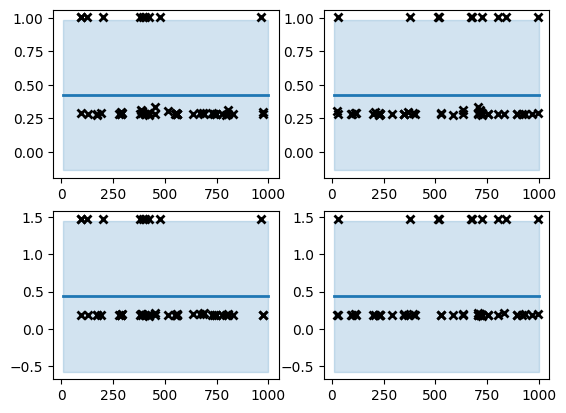

x_best =  [344.59256039 710.62708887]
acq_best =  [0.11211695 0.20136265]
C = [344.59256039 710.62708887]
Epoch 1/6
517/517 [==============================] - 3s 4ms/step - loss: 423041368064.0000 - mae: 538371.2500 - mse: 423040811008.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 3s 5ms/step - loss: 423041171456.0000 - mae: 538371.4375 - mse: 423040712704.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 3s 5ms/step - loss: 423041007616.0000 - mae: 538371.3750 - mse: 423040450560.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 3s 5ms/step - loss: 423041236992.0000 - mae: 538371.5625 - mse: 423040778240.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
517/517 [=======

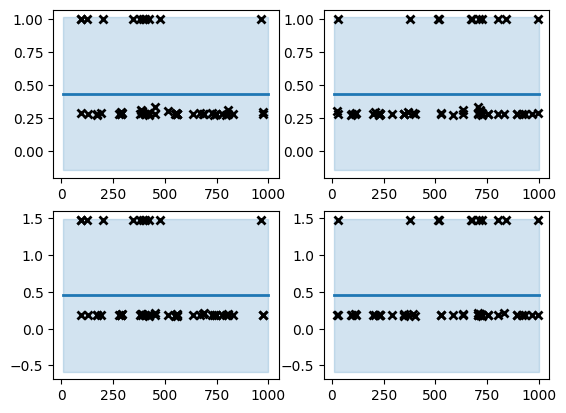

x_best =  [978.96214062 247.59139065]
acq_best =  [0.11542961 0.20732818]
C = [978.96214062 247.59139065]
Epoch 1/6
517/517 [==============================] - 4s 6ms/step - loss: 105273114624.0000 - mae: 206177.4688 - mse: 105272967168.0000 - val_loss: 59982434304.0000 - val_mae: 156568.6562 - val_mse: 59982278656.0000
Epoch 2/6
517/517 [==============================] - 3s 5ms/step - loss: 60939227136.0000 - mae: 163284.0000 - mse: 60939075584.0000 - val_loss: 58750590976.0000 - val_mae: 159756.7188 - val_mse: 58750447616.0000
Epoch 3/6
517/517 [==============================] - 3s 5ms/step - loss: 58082508800.0000 - mae: 159969.6250 - mse: 58082377728.0000 - val_loss: 55491485696.0000 - val_mae: 163684.3906 - val_mse: 55491325952.0000
Epoch 4/6
517/517 [==============================] - 3s 5ms/step - loss: 57426354176.0000 - mae: 159653.3906 - mse: 57426194432.0000 - val_loss: 54385172480.0000 - val_mae: 155909.8281 - val_mse: 54385000448.0000
Epoch 5/6
517/517 [=====================

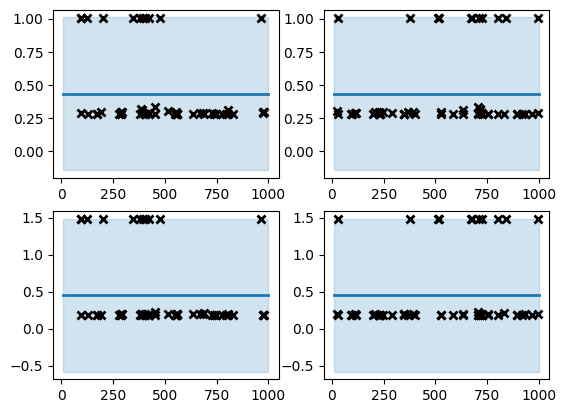

x_best =  [971.50151056 433.63988024]
acq_best =  [0.11461445 0.2058914 ]
C = [971.50151056 433.63988024]
Epoch 1/6
517/517 [==============================] - 4s 6ms/step - loss: 105877692416.0000 - mae: 206712.9375 - mse: 105877512192.0000 - val_loss: 70563880960.0000 - val_mae: 169433.7031 - val_mse: 70563700736.0000
Epoch 2/6
517/517 [==============================] - 3s 6ms/step - loss: 62370779136.0000 - mae: 164626.6094 - mse: 62370648064.0000 - val_loss: 60561096704.0000 - val_mae: 159566.0625 - val_mse: 60560932864.0000
Epoch 3/6
517/517 [==============================] - 3s 6ms/step - loss: 59861581824.0000 - mae: 162260.8750 - mse: 59861393408.0000 - val_loss: 56718237696.0000 - val_mae: 153129.4062 - val_mse: 56718073856.0000
Epoch 4/6
517/517 [==============================] - 4s 8ms/step - loss: 58173669376.0000 - mae: 160498.9531 - mse: 58173493248.0000 - val_loss: 55139344384.0000 - val_mae: 153577.6562 - val_mse: 55139184640.0000
Epoch 5/6
517/517 [=====================

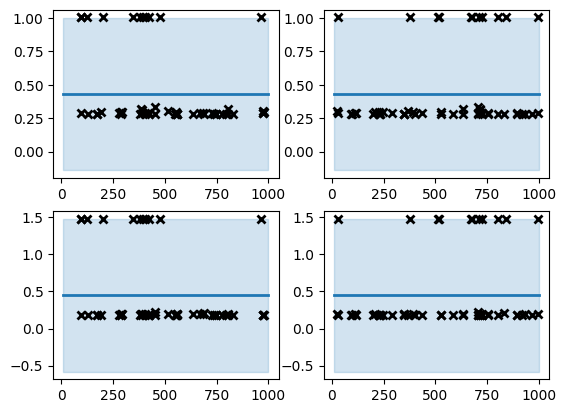

x_best =  [684.15045927 945.33672572]
acq_best =  [0.11383182 0.20449009]
C = [684.15045927 945.33672572]
Epoch 1/6
517/517 [==============================] - 6s 9ms/step - loss: 423041138688.0000 - mae: 538371.1875 - mse: 423040778240.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 4s 9ms/step - loss: 423041204224.0000 - mae: 538371.3750 - mse: 423040745472.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 5s 9ms/step - loss: 423041269760.0000 - mae: 538371.8125 - mse: 423040778240.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 5s 9ms/step - loss: 423041400832.0000 - mae: 538371.6250 - mse: 423040876544.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
517/517 [=======

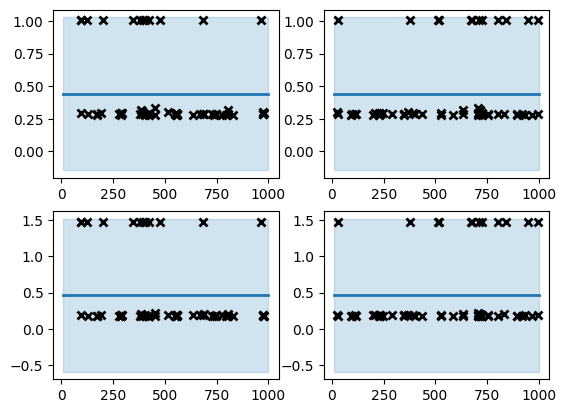

x_best =  [ 17.06353239 222.77842237]
acq_best =  [0.11682307 0.20987537]
C = [ 17.06353239 222.77842237]
Epoch 1/6
517/517 [==============================] - 3s 3ms/step - loss: 158683627520.0000 - mae: 257838.9844 - mse: 158683398144.0000 - val_loss: 119575568384.0000 - val_mae: 221436.4062 - val_mse: 119575339008.0000
Epoch 2/6
517/517 [==============================] - 1s 3ms/step - loss: 107021508608.0000 - mae: 207499.6719 - mse: 107021295616.0000 - val_loss: 92154126336.0000 - val_mae: 192470.5625 - val_mse: 92153978880.0000
Epoch 3/6
517/517 [==============================] - 1s 3ms/step - loss: 75284447232.0000 - mae: 173748.8750 - mse: 75284275200.0000 - val_loss: 65358524416.0000 - val_mae: 176240.3125 - val_mse: 65358389248.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 61604069376.0000 - mae: 161152.9844 - mse: 61603926016.0000 - val_loss: 57778626560.0000 - val_mae: 157050.4062 - val_mse: 57778466816.0000
Epoch 5/6
517/517 [=================

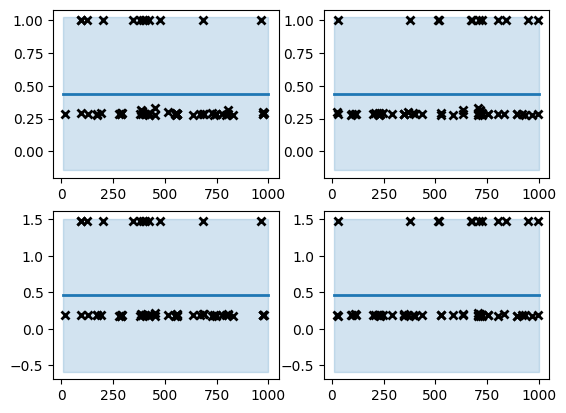

x_best =  [836.45746293 995.76587602]
acq_best =  [0.11607974 0.20844882]
C = [836.45746293 995.76587602]
Epoch 1/6
517/517 [==============================] - 5s 9ms/step - loss: 423041040384.0000 - mae: 538371.8750 - mse: 423040647168.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 5s 9ms/step - loss: 423041204224.0000 - mae: 538371.5625 - mse: 423040745472.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 5s 9ms/step - loss: 423041531904.0000 - mae: 538371.6250 - mse: 423040843776.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 5s 10ms/step - loss: 423041433600.0000 - mae: 538371.4375 - mse: 423040811008.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
517/517 [======

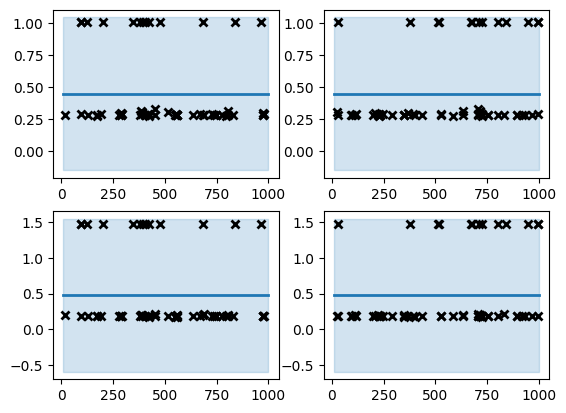

x_best =  [219.28466391 235.83504993]
acq_best =  [0.11878925 0.21335591]
C = [219.28466391 235.83504993]
Epoch 1/6
517/517 [==============================] - 3s 4ms/step - loss: 133394137088.0000 - mae: 233265.7656 - mse: 133393924096.0000 - val_loss: 92389007360.0000 - val_mae: 196294.3594 - val_mse: 92388818944.0000
Epoch 2/6
517/517 [==============================] - 1s 3ms/step - loss: 69783068672.0000 - mae: 169113.8906 - mse: 69782921216.0000 - val_loss: 58542333952.0000 - val_mae: 164423.5938 - val_mse: 58542182400.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 60440518656.0000 - mae: 163395.8594 - mse: 60440367104.0000 - val_loss: 55528996864.0000 - val_mae: 154675.3750 - val_mse: 55528849408.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 59555921920.0000 - mae: 161979.5312 - mse: 59555741696.0000 - val_loss: 54951723008.0000 - val_mae: 158757.8281 - val_mse: 54951563264.0000
Epoch 5/6
517/517 [=====================

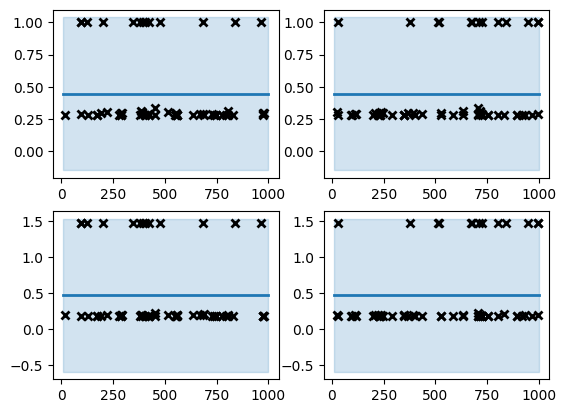

x_best =  [944.84595433 785.79912323]
acq_best =  [0.11799776 0.21202438]
C = [944.84595433 785.79912323]
Epoch 1/6
517/517 [==============================] - 10s 16ms/step - loss: 105219768320.0000 - mae: 203521.8281 - mse: 105219547136.0000 - val_loss: 58303844352.0000 - val_mae: 160875.1562 - val_mse: 58303684608.0000
Epoch 2/6
517/517 [==============================] - 6s 12ms/step - loss: 60624199680.0000 - mae: 163432.9688 - mse: 60624003072.0000 - val_loss: 55149334528.0000 - val_mae: 156755.8281 - val_mse: 55149187072.0000
Epoch 3/6
517/517 [==============================] - 5s 10ms/step - loss: 58862346240.0000 - mae: 161245.7188 - mse: 58862194688.0000 - val_loss: 54511087616.0000 - val_mae: 160599.8906 - val_mse: 54510940160.0000
Epoch 4/6
517/517 [==============================] - 4s 7ms/step - loss: 58165891072.0000 - mae: 160255.9688 - mse: 58165735424.0000 - val_loss: 53953122304.0000 - val_mae: 156076.2500 - val_mse: 53952933888.0000
Epoch 5/6
517/517 [=================

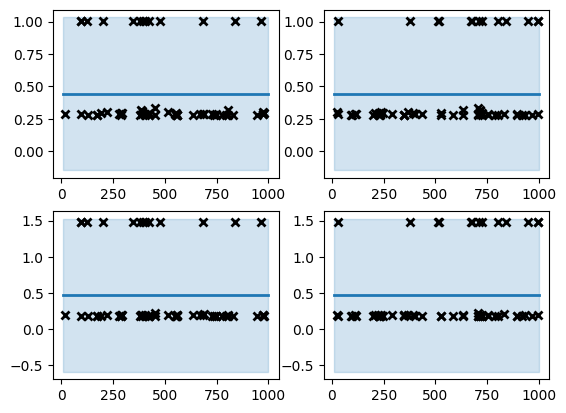

x_best =  [442.0455858  644.93302468]
acq_best =  [0.11731751 0.21076173]
C = [442.0455858  644.93302468]
Epoch 1/6
517/517 [==============================] - 3s 4ms/step - loss: 108136595456.0000 - mae: 209501.1875 - mse: 108136431616.0000 - val_loss: 63543730176.0000 - val_mae: 163426.1562 - val_mse: 63543578624.0000
Epoch 2/6
517/517 [==============================] - 2s 3ms/step - loss: 63023005696.0000 - mae: 165742.3125 - mse: 63022858240.0000 - val_loss: 58275762176.0000 - val_mae: 168059.5156 - val_mse: 58275577856.0000
Epoch 3/6
517/517 [==============================] - 2s 3ms/step - loss: 59743051776.0000 - mae: 162301.5625 - mse: 59742904320.0000 - val_loss: 54292492288.0000 - val_mae: 153988.7031 - val_mse: 54292328448.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 58521415680.0000 - mae: 160970.4688 - mse: 58521300992.0000 - val_loss: 57577324544.0000 - val_mae: 166597.6406 - val_mse: 57577144320.0000
Epoch 5/6
517/517 [=====================

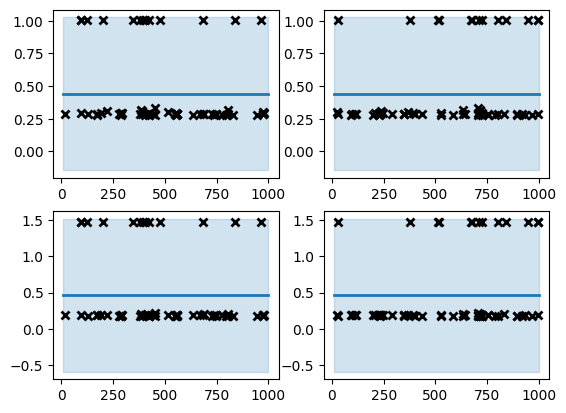

x_best =  [887.78097378 743.72696898]
acq_best =  [0.11663044 0.2094611 ]
C = [887.78097378 743.72696898]
Epoch 1/6
517/517 [==============================] - 9s 14ms/step - loss: 100850925568.0000 - mae: 201331.1875 - mse: 100850728960.0000 - val_loss: 58079830016.0000 - val_mae: 156042.3125 - val_mse: 58079670272.0000
Epoch 2/6
517/517 [==============================] - 6s 11ms/step - loss: 59833585664.0000 - mae: 162013.7812 - mse: 59833380864.0000 - val_loss: 55168815104.0000 - val_mae: 154172.4844 - val_mse: 55168659456.0000
Epoch 3/6
517/517 [==============================] - 6s 11ms/step - loss: 57813905408.0000 - mae: 160076.0156 - mse: 57813741568.0000 - val_loss: 53889581056.0000 - val_mae: 152399.5781 - val_mse: 53889433600.0000
Epoch 4/6
517/517 [==============================] - 4s 8ms/step - loss: 56965193728.0000 - mae: 159215.2969 - mse: 56965013504.0000 - val_loss: 54113972224.0000 - val_mae: 153117.9688 - val_mse: 54113816576.0000
Epoch 5/6
517/517 [==================

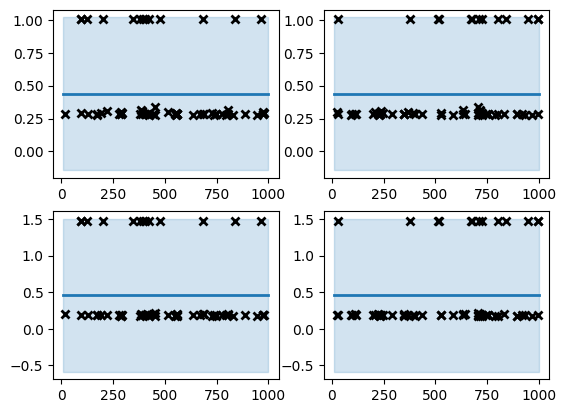

x_best =  [630.5810784  136.58581858]
acq_best =  [0.11593893 0.20818944]
C = [630.5810784  136.58581858]
Epoch 1/6
517/517 [==============================] - 3s 4ms/step - loss: 119163338752.0000 - mae: 218444.2500 - mse: 119163133952.0000 - val_loss: 73798778880.0000 - val_mae: 165169.4531 - val_mse: 73798582272.0000
Epoch 2/6
517/517 [==============================] - 2s 3ms/step - loss: 64326492160.0000 - mae: 165385.2344 - mse: 64326299648.0000 - val_loss: 60917198848.0000 - val_mae: 173737.0000 - val_mse: 60917047296.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 59002388480.0000 - mae: 160028.3281 - mse: 59002216448.0000 - val_loss: 55333195776.0000 - val_mae: 163045.9219 - val_mse: 55333036032.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 57551994880.0000 - mae: 158239.7656 - mse: 57551835136.0000 - val_loss: 52793909248.0000 - val_mae: 154027.1094 - val_mse: 52793757696.0000
Epoch 5/6
517/517 [=====================

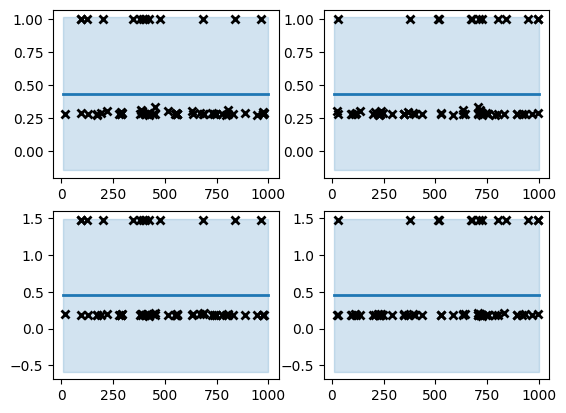

x_best =  [335.98655017 749.35710843]
acq_best =  [0.11521101 0.20697387]
C = [335.98655017 749.35710843]
Epoch 1/6
517/517 [==============================] - 3s 4ms/step - loss: 423040909312.0000 - mae: 538371.6250 - mse: 423040483328.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 423041105920.0000 - mae: 538371.3125 - mse: 423040548864.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 2s 5ms/step - loss: 423041171456.0000 - mae: 538371.3750 - mse: 423040712704.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 3s 6ms/step - loss: 423041335296.0000 - mae: 538371.5000 - mse: 423040778240.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
517/517 [=======

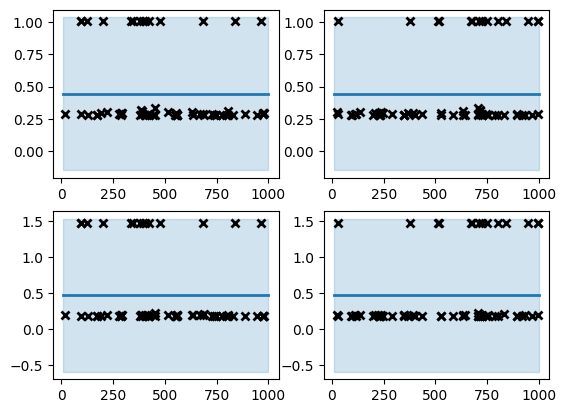

x_best =  [540.85523253 936.44059909]
acq_best =  [0.11773036 0.21151047]
C = [540.85523253 936.44059909]
Epoch 1/6
517/517 [==============================] - 4s 7ms/step - loss: 423041171456.0000 - mae: 538371.5000 - mse: 423040548864.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 4s 7ms/step - loss: 423041236992.0000 - mae: 538371.4375 - mse: 423040745472.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 5s 10ms/step - loss: 423041171456.0000 - mae: 538371.5625 - mse: 423040647168.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 5s 10ms/step - loss: 423041335296.0000 - mae: 538371.3125 - mse: 423040876544.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
517/517 [=====

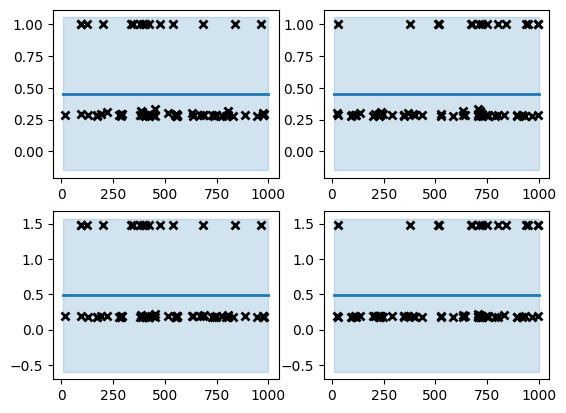

x_best =  [ 73.95129547 470.1521137 ]
acq_best =  [0.12003195 0.21564537]
C = [ 73.95129547 470.1521137 ]
Epoch 1/6
517/517 [==============================] - 2s 2ms/step - loss: 132551286784.0000 - mae: 231306.0469 - mse: 132551032832.0000 - val_loss: 101609086976.0000 - val_mae: 216041.3594 - val_mse: 101608849408.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 75127824384.0000 - mae: 174707.1562 - mse: 75127635968.0000 - val_loss: 61179908096.0000 - val_mae: 171113.0156 - val_mse: 61179723776.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 60829896704.0000 - mae: 162944.3125 - mse: 60829720576.0000 - val_loss: 56745082880.0000 - val_mae: 157113.0781 - val_mse: 56744927232.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 59056291840.0000 - mae: 161045.7656 - mse: 59056156672.0000 - val_loss: 57932169216.0000 - val_mae: 158595.4375 - val_mse: 57931997184.0000
Epoch 5/6
517/517 [===================

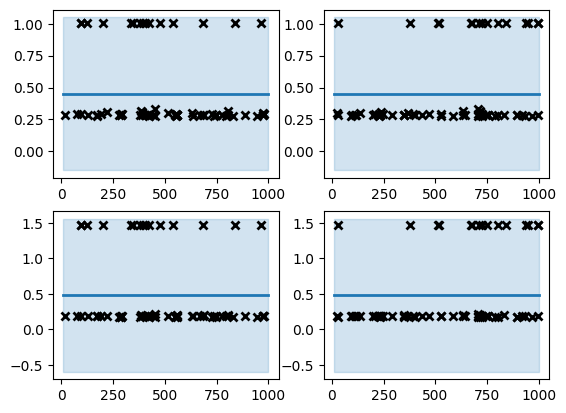

x_best =  [746.98583853 556.96141438]
acq_best =  [0.11937467 0.21448714]
C = [746.98583853 556.96141438]
Epoch 1/6
517/517 [==============================] - 3s 5ms/step - loss: 423041433600.0000 - mae: 538371.7500 - mse: 423041007616.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 3s 5ms/step - loss: 423041236992.0000 - mae: 538371.7500 - mse: 423040581632.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 3s 5ms/step - loss: 423041368064.0000 - mae: 538371.0625 - mse: 423040942080.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 3s 6ms/step - loss: 423041138688.0000 - mae: 538371.3125 - mse: 423040581632.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
517/517 [=======

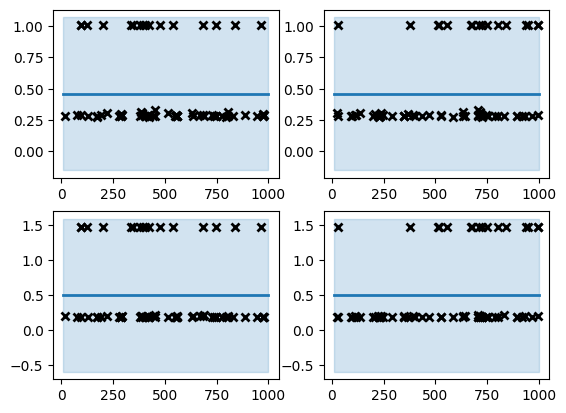

x_best =  [670.15424476 228.93159153]
acq_best =  [0.1214899  0.21828897]
C = [670.15424476 228.93159153]
Epoch 1/6
517/517 [==============================] - 2s 3ms/step - loss: 117535203328.0000 - mae: 215934.2812 - mse: 117534973952.0000 - val_loss: 71197728768.0000 - val_mae: 163940.8438 - val_mse: 71197548544.0000
Epoch 2/6
517/517 [==============================] - 2s 3ms/step - loss: 63389917184.0000 - mae: 164805.9219 - mse: 63389741056.0000 - val_loss: 57411547136.0000 - val_mae: 163799.8281 - val_mse: 57411387392.0000
Epoch 3/6
517/517 [==============================] - 2s 3ms/step - loss: 59466334208.0000 - mae: 161715.4688 - mse: 59466211328.0000 - val_loss: 57550663680.0000 - val_mae: 155758.5156 - val_mse: 57550512128.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 58601828352.0000 - mae: 161540.0938 - mse: 58601689088.0000 - val_loss: 53813444608.0000 - val_mae: 153737.9375 - val_mse: 53813293056.0000
Epoch 5/6
517/517 [=====================

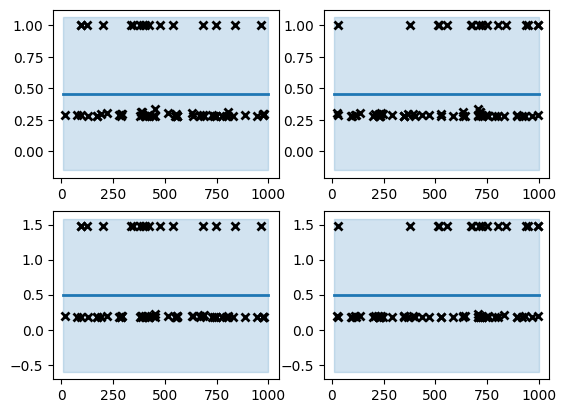

x_best =  [876.95473664 663.29272575]
acq_best =  [0.12089859 0.21716278]
C = [876.95473664 663.29272575]
Epoch 1/6
517/517 [==============================] - 8s 13ms/step - loss: 423041269760.0000 - mae: 538371.5000 - mse: 423040712704.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 5s 10ms/step - loss: 423041171456.0000 - mae: 538371.4375 - mse: 423040745472.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 5s 10ms/step - loss: 423041302528.0000 - mae: 538371.2500 - mse: 423040679936.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 3s 6ms/step - loss: 423041564672.0000 - mae: 538371.3750 - mse: 423040974848.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
517/517 [====

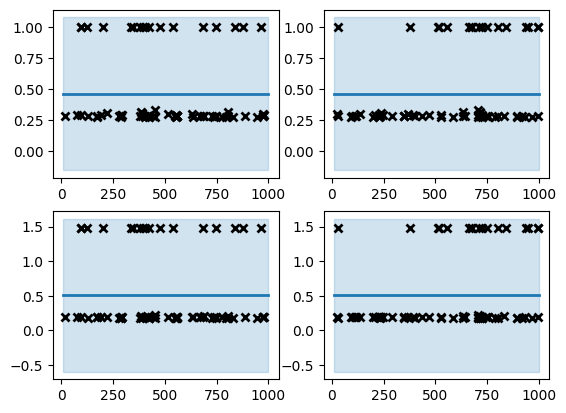

x_best =  [254.7705635  768.52025175]
acq_best =  [0.1228384  0.22068632]
C = [254.7705635  768.52025175]
Epoch 1/6
517/517 [==============================] - 2s 2ms/step - loss: 126390575104.0000 - mae: 227836.1562 - mse: 126390386688.0000 - val_loss: 75749146624.0000 - val_mae: 188425.8281 - val_mse: 75748950016.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 63629680640.0000 - mae: 165750.7656 - mse: 63629492224.0000 - val_loss: 54709039104.0000 - val_mae: 155761.1406 - val_mse: 54708895744.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 58683559936.0000 - mae: 160764.5000 - mse: 58683371520.0000 - val_loss: 54731755520.0000 - val_mae: 154267.1250 - val_mse: 54731603968.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 58212978688.0000 - mae: 160252.0625 - mse: 58212835328.0000 - val_loss: 56450035712.0000 - val_mae: 164339.7031 - val_mse: 56449875968.0000
Epoch 5/6
517/517 [=====================

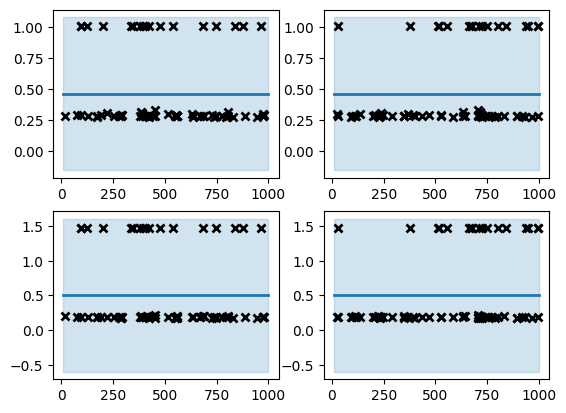

x_best =  [680.66425498 578.29828823]
acq_best =  [0.12224749 0.21957555]
C = [680.66425498 578.29828823]
Epoch 1/6
517/517 [==============================] - 3s 5ms/step - loss: 423041236992.0000 - mae: 538371.6875 - mse: 423040712704.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 3s 6ms/step - loss: 423041433600.0000 - mae: 538371.5000 - mse: 423040647168.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 3s 6ms/step - loss: 423041499136.0000 - mae: 538371.8125 - mse: 423040974848.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 3s 7ms/step - loss: 423041105920.0000 - mae: 538371.4375 - mse: 423040647168.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
517/517 [=======

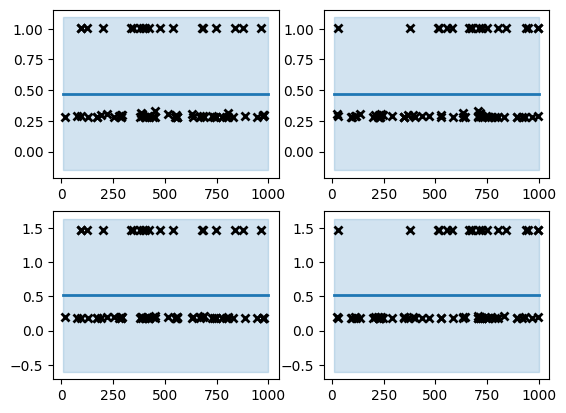

x_best =  [826.62551751 744.27658569]
acq_best =  [0.1240553  0.22282787]
C = [826.62551751 744.27658569]
Epoch 1/6
517/517 [==============================] - 4s 7ms/step - loss: 423041400832.0000 - mae: 538371.1250 - mse: 423040778240.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 4s 7ms/step - loss: 423041269760.0000 - mae: 538371.0625 - mse: 423040483328.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 4s 8ms/step - loss: 423041335296.0000 - mae: 538371.3750 - mse: 423040942080.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 4s 8ms/step - loss: 423041662976.0000 - mae: 538371.3750 - mse: 423040974848.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
517/517 [=======

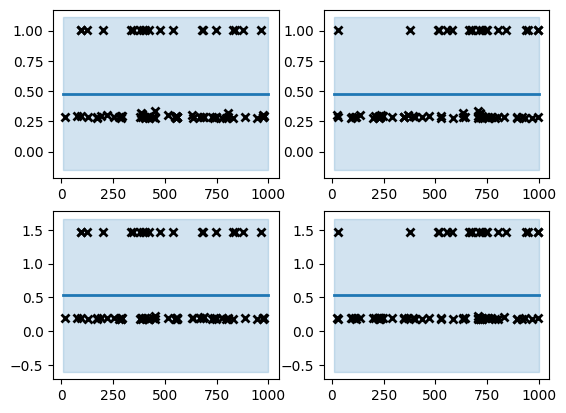

x_best =  [329.11999872 343.04318053]
acq_best =  [0.12572884 0.22581931]
C = [329.11999872 343.04318053]
Epoch 1/6
517/517 [==============================] - 5s 7ms/step - loss: 123270504448.0000 - mae: 221445.6875 - mse: 123270316032.0000 - val_loss: 81245921280.0000 - val_mae: 191053.5156 - val_mse: 81245724672.0000
Epoch 2/6
517/517 [==============================] - 3s 6ms/step - loss: 65413824512.0000 - mae: 166363.5156 - mse: 65413648384.0000 - val_loss: 55954751488.0000 - val_mae: 156076.9531 - val_mse: 55954604032.0000
Epoch 3/6
517/517 [==============================] - 3s 5ms/step - loss: 59277238272.0000 - mae: 161606.4688 - mse: 59277033472.0000 - val_loss: 54441852928.0000 - val_mae: 154114.2656 - val_mse: 54441693184.0000
Epoch 4/6
517/517 [==============================] - 3s 5ms/step - loss: 57130098688.0000 - mae: 157622.2188 - mse: 57129922560.0000 - val_loss: 60608237568.0000 - val_mae: 172124.5781 - val_mse: 60608065536.0000
Epoch 5/6
517/517 [=====================

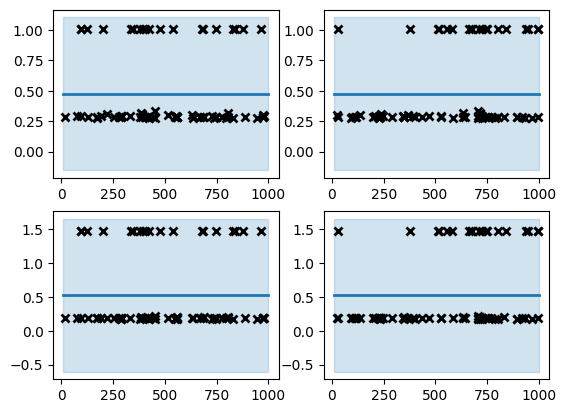

x_best =  [845.18220441 947.2628271 ]
acq_best =  [0.12515369 0.22481662]
C = [845.18220441 947.2628271 ]
Epoch 1/6
517/517 [==============================] - 9s 14ms/step - loss: 106826252288.0000 - mae: 208257.7812 - mse: 106826022912.0000 - val_loss: 68508839936.0000 - val_mae: 193088.4219 - val_mse: 68508647424.0000
Epoch 2/6
517/517 [==============================] - 6s 12ms/step - loss: 61621297152.0000 - mae: 164663.7812 - mse: 61621137408.0000 - val_loss: 58140262400.0000 - val_mae: 155827.5469 - val_mse: 58140114944.0000
Epoch 3/6
517/517 [==============================] - 7s 13ms/step - loss: 58732843008.0000 - mae: 161155.2344 - mse: 58732691456.0000 - val_loss: 56302342144.0000 - val_mae: 152252.2656 - val_mse: 56302190592.0000
Epoch 4/6
517/517 [==============================] - 5s 11ms/step - loss: 57024106496.0000 - mae: 158985.7969 - mse: 57023946752.0000 - val_loss: 56485871616.0000 - val_mae: 160664.1094 - val_mse: 56485707776.0000
Epoch 5/6
517/517 [=================

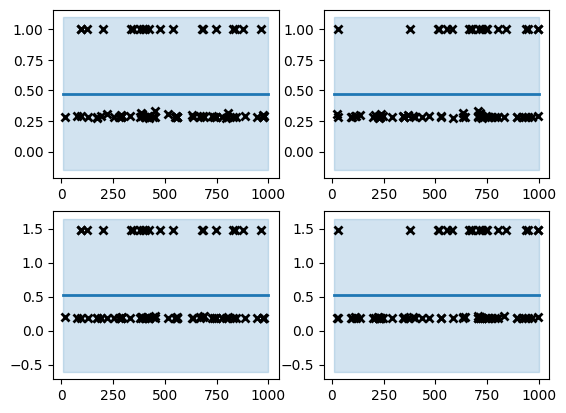

x_best =  [340.19012173 113.42568018]
acq_best =  [0.12461383 0.2238121 ]
C = [340.19012173 113.42568018]
Epoch 1/6
517/517 [==============================] - 3s 3ms/step - loss: 128480157696.0000 - mae: 229099.0781 - mse: 128479895552.0000 - val_loss: 96364634112.0000 - val_mae: 188776.6406 - val_mse: 96364421120.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 70804267008.0000 - mae: 170886.3281 - mse: 70804086784.0000 - val_loss: 81301127168.0000 - val_mae: 187892.6094 - val_mse: 81300946944.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 59996516352.0000 - mae: 161927.2656 - mse: 59996356608.0000 - val_loss: 59696652288.0000 - val_mae: 173819.1562 - val_mse: 59696492544.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 57981026304.0000 - mae: 160066.1562 - mse: 57980870656.0000 - val_loss: 55117979648.0000 - val_mae: 159570.6250 - val_mse: 55117807616.0000
Epoch 5/6
517/517 [=====================

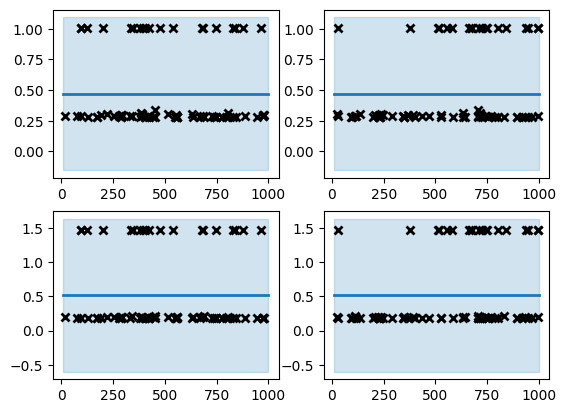

x_best =  [842.08198399 947.8602787 ]
acq_best =  [0.12405996 0.22274957]
C = [842.08198399 947.8602787 ]
Epoch 1/6
517/517 [==============================] - 9s 15ms/step - loss: 97971322880.0000 - mae: 200406.8125 - mse: 97971167232.0000 - val_loss: 59436380160.0000 - val_mae: 171960.5938 - val_mse: 59436212224.0000
Epoch 2/6
517/517 [==============================] - 7s 14ms/step - loss: 60355346432.0000 - mae: 163232.3594 - mse: 60355178496.0000 - val_loss: 55773884416.0000 - val_mae: 156810.3281 - val_mse: 55773716480.0000
Epoch 3/6
517/517 [==============================] - 7s 13ms/step - loss: 58877407232.0000 - mae: 162081.7812 - mse: 58877218816.0000 - val_loss: 54102007808.0000 - val_mae: 157784.2500 - val_mse: 54101864448.0000
Epoch 4/6
517/517 [==============================] - 6s 12ms/step - loss: 57191571456.0000 - mae: 159409.3125 - mse: 57191415808.0000 - val_loss: 56584224768.0000 - val_mae: 160973.9688 - val_mse: 56584077312.0000
Epoch 5/6
517/517 [===================

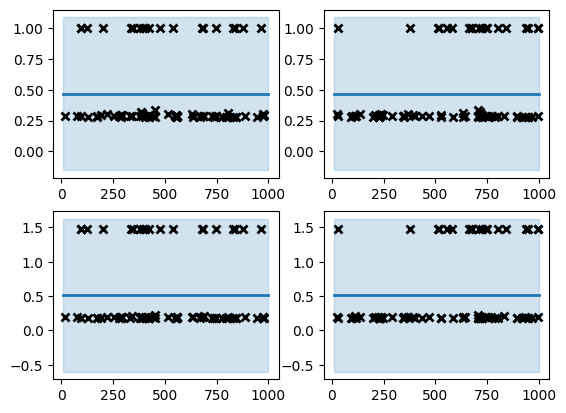

x_best =  [238.14970495 754.78693711]
acq_best =  [0.12352677 0.22176638]
C = [238.14970495 754.78693711]
Epoch 1/6
517/517 [==============================] - 2s 3ms/step - loss: 423041073152.0000 - mae: 538371.8125 - mse: 423040516096.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 2s 3ms/step - loss: 423041400832.0000 - mae: 538371.2500 - mse: 423040909312.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 2s 3ms/step - loss: 423041105920.0000 - mae: 538371.5000 - mse: 423040581632.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 423041368064.0000 - mae: 538371.3750 - mse: 423040679936.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
517/517 [=======

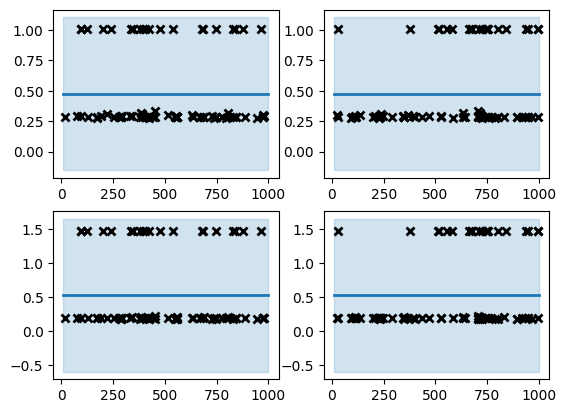

x_best =  [271.51412819 473.43734472]
acq_best =  [0.12511611 0.22462955]
C = [271.51412819 473.43734472]
Epoch 1/6
517/517 [==============================] - 4s 6ms/step - loss: 121446785024.0000 - mae: 221378.5000 - mse: 121446563840.0000 - val_loss: 73176596480.0000 - val_mae: 173606.9062 - val_mse: 73176383488.0000
Epoch 2/6
517/517 [==============================] - 2s 5ms/step - loss: 65089982464.0000 - mae: 167220.8125 - mse: 65089810432.0000 - val_loss: 60086419456.0000 - val_mae: 160320.9531 - val_mse: 60086255616.0000
Epoch 3/6
517/517 [==============================] - 2s 5ms/step - loss: 58999582720.0000 - mae: 160288.7656 - mse: 58999410688.0000 - val_loss: 66678214656.0000 - val_mae: 172813.3750 - val_mse: 66678050816.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 57651658752.0000 - mae: 158515.4531 - mse: 57651486720.0000 - val_loss: 57882992640.0000 - val_mae: 158429.4844 - val_mse: 57882845184.0000
Epoch 5/6
517/517 [=====================

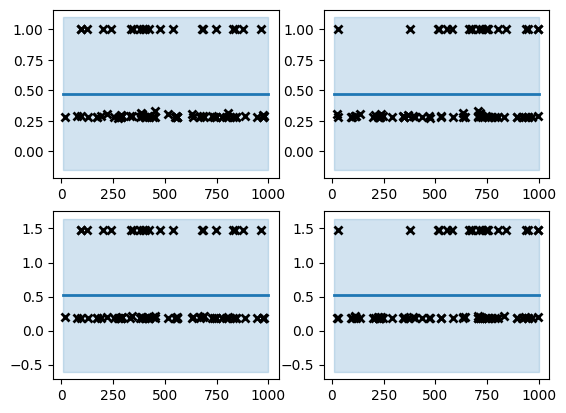

x_best =  [253.5630726  754.27662784]
acq_best =  [0.12462286 0.22370581]
C = [253.5630726  754.27662784]
Epoch 1/6
517/517 [==============================] - 4s 5ms/step - loss: 118437855232.0000 - mae: 216679.2344 - mse: 118437601280.0000 - val_loss: 69807095808.0000 - val_mae: 173026.4844 - val_mse: 69806923776.0000
Epoch 2/6
517/517 [==============================] - 2s 5ms/step - loss: 63081750528.0000 - mae: 164488.2031 - mse: 63081570304.0000 - val_loss: 56012414976.0000 - val_mae: 156656.5312 - val_mse: 56012275712.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 59054788608.0000 - mae: 161432.5000 - mse: 59054628864.0000 - val_loss: 59802447872.0000 - val_mae: 175935.0000 - val_mse: 59802284032.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 57053401088.0000 - mae: 159250.4688 - mse: 57053237248.0000 - val_loss: 56065167360.0000 - val_mae: 152272.1250 - val_mse: 56065024000.0000
Epoch 5/6
517/517 [=====================

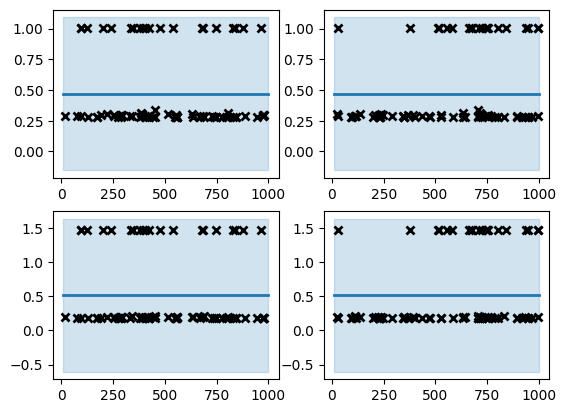

x_best =  [574.18290305 430.13723495]
acq_best =  [0.12407635 0.2227691 ]
C = [574.18290305 430.13723495]
Epoch 1/6
517/517 [==============================] - 4s 6ms/step - loss: 111604285440.0000 - mae: 211824.3594 - mse: 111604097024.0000 - val_loss: 60877819904.0000 - val_mae: 162559.0938 - val_mse: 60877647872.0000
Epoch 2/6
517/517 [==============================] - 3s 6ms/step - loss: 62164344832.0000 - mae: 164822.2656 - mse: 62164148224.0000 - val_loss: 55229722624.0000 - val_mae: 155073.4688 - val_mse: 55229583360.0000
Epoch 3/6
517/517 [==============================] - 3s 5ms/step - loss: 57702965248.0000 - mae: 159302.3281 - mse: 57702801408.0000 - val_loss: 56327647232.0000 - val_mae: 152013.9531 - val_mse: 56327495680.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 57025060864.0000 - mae: 158702.3438 - mse: 57024892928.0000 - val_loss: 55937720320.0000 - val_mae: 163048.9219 - val_mse: 55937544192.0000
Epoch 5/6
517/517 [=====================

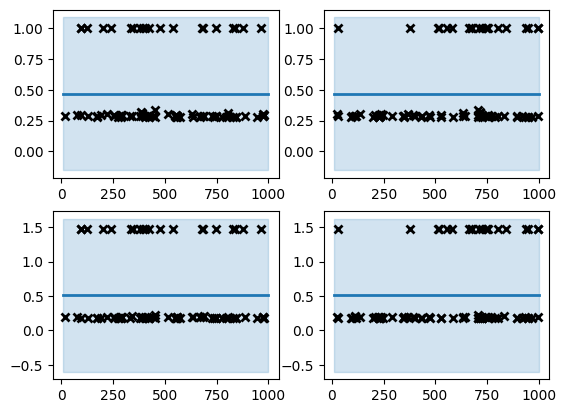

x_best =  [187.05830238  47.7040678 ]
acq_best =  [0.12358892 0.22180895]
C = [187.05830238  47.7040678 ]
Epoch 1/6
517/517 [==============================] - 3s 4ms/step - loss: 140949307392.0000 - mae: 238933.4844 - mse: 140949078016.0000 - val_loss: 116537712640.0000 - val_mae: 215233.2969 - val_mse: 116537483264.0000
Epoch 2/6
517/517 [==============================] - 2s 3ms/step - loss: 94771576832.0000 - mae: 192336.2812 - mse: 94771380224.0000 - val_loss: 74445094912.0000 - val_mae: 181663.0312 - val_mse: 74444898304.0000
Epoch 3/6
517/517 [==============================] - 2s 3ms/step - loss: 65738653696.0000 - mae: 165152.8281 - mse: 65738514432.0000 - val_loss: 60797337600.0000 - val_mae: 160221.0781 - val_mse: 60797186048.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 61789196288.0000 - mae: 163829.0156 - mse: 61789011968.0000 - val_loss: 60232695808.0000 - val_mae: 160272.5938 - val_mse: 60232552448.0000
Epoch 5/6
517/517 [===================

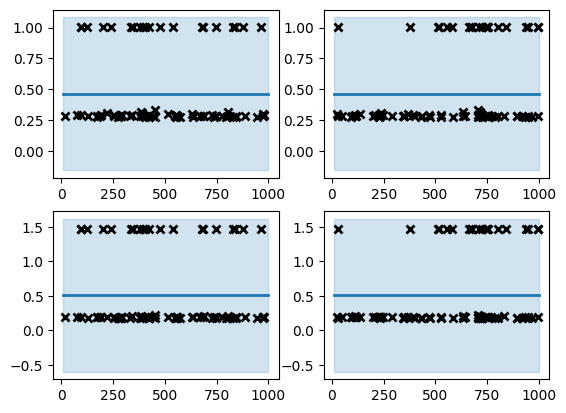

x_best =  [423.58713363 288.68349896]
acq_best =  [0.12307229 0.22088364]
C = [423.58713363 288.68349896]
Epoch 1/6
517/517 [==============================] - 3s 5ms/step - loss: 423041269760.0000 - mae: 538371.6250 - mse: 423040712704.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 423041564672.0000 - mae: 538371.5000 - mse: 423040974848.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 2s 3ms/step - loss: 423041269760.0000 - mae: 538371.6250 - mse: 423040778240.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 423041302528.0000 - mae: 538371.5000 - mse: 423040679936.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
517/517 [=======

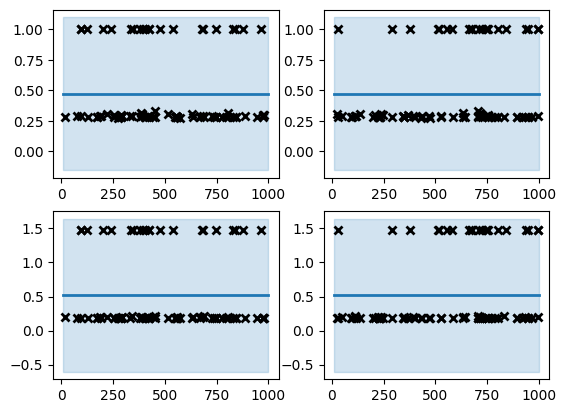

x_best =  [ 49.9179919  191.58162933]
acq_best =  [0.12459894 0.22364064]
C = [ 49.9179919  191.58162933]
Epoch 1/6
517/517 [==============================] - 3s 3ms/step - loss: 145151639552.0000 - mae: 246158.0156 - mse: 145151426560.0000 - val_loss: 116957388800.0000 - val_mae: 224810.5000 - val_mse: 116957134848.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 97484562432.0000 - mae: 195539.5938 - mse: 97484333056.0000 - val_loss: 73587367936.0000 - val_mae: 166746.7656 - val_mse: 73587228672.0000
Epoch 3/6
517/517 [==============================] - 2s 3ms/step - loss: 66474885120.0000 - mae: 166454.0312 - mse: 66474692608.0000 - val_loss: 62883938304.0000 - val_mae: 167611.6406 - val_mse: 62883778560.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 62597332992.0000 - mae: 164542.0625 - mse: 62597185536.0000 - val_loss: 58443173888.0000 - val_mae: 163099.9375 - val_mse: 58443005952.0000
Epoch 5/6
517/517 [===================

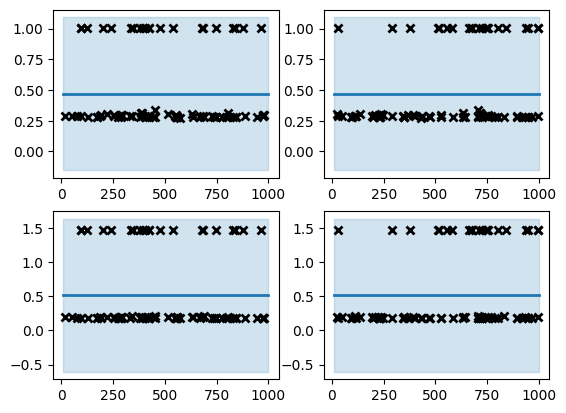

x_best =  [727.6059917  910.43562424]
acq_best =  [0.12409689 0.22272318]
C = [727.6059917  910.43562424]
Epoch 1/6
517/517 [==============================] - 5s 7ms/step - loss: 102580953088.0000 - mae: 204656.8750 - mse: 102580772864.0000 - val_loss: 61979537408.0000 - val_mae: 159706.1719 - val_mse: 61979361280.0000
Epoch 2/6
517/517 [==============================] - 4s 8ms/step - loss: 60643074048.0000 - mae: 164052.6406 - mse: 60642869248.0000 - val_loss: 61997834240.0000 - val_mae: 173687.6719 - val_mse: 61997694976.0000
Epoch 3/6
517/517 [==============================] - 4s 8ms/step - loss: 59227705344.0000 - mae: 161982.4531 - mse: 59227553792.0000 - val_loss: 55037460480.0000 - val_mae: 160810.9375 - val_mse: 55037304832.0000
Epoch 4/6
517/517 [==============================] - 4s 8ms/step - loss: 58071818240.0000 - mae: 160693.7188 - mse: 58071674880.0000 - val_loss: 56935075840.0000 - val_mae: 155599.4062 - val_mse: 56934895616.0000
Epoch 5/6
517/517 [=====================

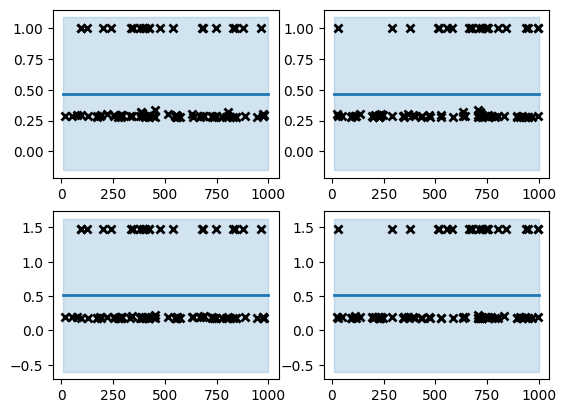

x_best =  [737.74687133 651.72102335]
acq_best =  [0.12362087 0.22181224]
C = [737.74687133 651.72102335]
Epoch 1/6
517/517 [==============================] - 4s 6ms/step - loss: 104455168000.0000 - mae: 206912.0781 - mse: 104454955008.0000 - val_loss: 65582325760.0000 - val_mae: 185744.7812 - val_mse: 65582125056.0000
Epoch 2/6
517/517 [==============================] - 3s 5ms/step - loss: 60570869760.0000 - mae: 163672.1250 - mse: 60570681344.0000 - val_loss: 64642646016.0000 - val_mae: 183684.5781 - val_mse: 64642457600.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 58313895936.0000 - mae: 160221.5469 - mse: 58313703424.0000 - val_loss: 55154544640.0000 - val_mae: 163251.6562 - val_mse: 55154372608.0000
Epoch 4/6
517/517 [==============================] - 2s 5ms/step - loss: 57028976640.0000 - mae: 158801.2812 - mse: 57028816896.0000 - val_loss: 53276196864.0000 - val_mae: 157123.4062 - val_mse: 53276045312.0000
Epoch 5/6
517/517 [=====================

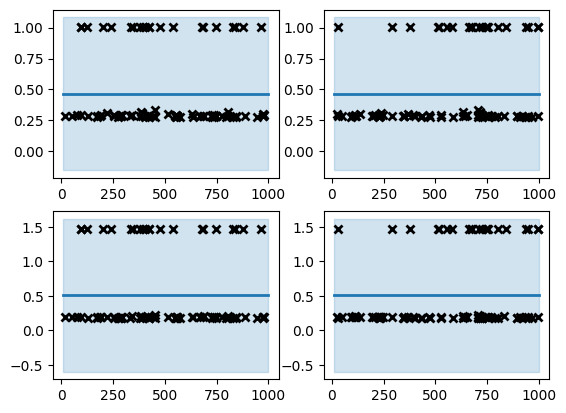

x_best =  [994.4874529  188.60813853]
acq_best =  [0.12310837 0.22093235]
C = [994.4874529  188.60813853]
Epoch 1/6
517/517 [==============================] - 5s 6ms/step - loss: 113472446464.0000 - mae: 211452.5469 - mse: 113472233472.0000 - val_loss: 62987218944.0000 - val_mae: 161365.0625 - val_mse: 62987055104.0000
Epoch 2/6
517/517 [==============================] - 3s 6ms/step - loss: 62941847552.0000 - mae: 164200.9531 - mse: 62941667328.0000 - val_loss: 56815804416.0000 - val_mae: 154298.4531 - val_mse: 56815669248.0000
Epoch 3/6
517/517 [==============================] - 3s 6ms/step - loss: 59919249408.0000 - mae: 162133.0156 - mse: 59919073280.0000 - val_loss: 54803820544.0000 - val_mae: 156655.3594 - val_mse: 54803685376.0000
Epoch 4/6
517/517 [==============================] - 3s 6ms/step - loss: 57793830912.0000 - mae: 158379.9531 - mse: 57793654784.0000 - val_loss: 52920713216.0000 - val_mae: 154527.3906 - val_mse: 52920561664.0000
Epoch 5/6
517/517 [=====================

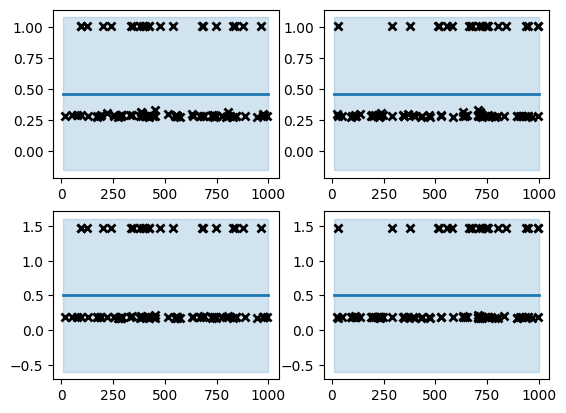

x_best =  [902.5321446  815.57863152]
acq_best =  [0.12263135 0.22004319]
C = [902.5321446  815.57863152]
Epoch 1/6
517/517 [==============================] - 6s 11ms/step - loss: 423041138688.0000 - mae: 538371.6250 - mse: 423040548864.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 6s 11ms/step - loss: 423041138688.0000 - mae: 538371.5625 - mse: 423040778240.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 6s 11ms/step - loss: 423041138688.0000 - mae: 538371.5625 - mse: 423040679936.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 5s 10ms/step - loss: 423041105920.0000 - mae: 538371.4375 - mse: 423040385024.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
517/517 [===

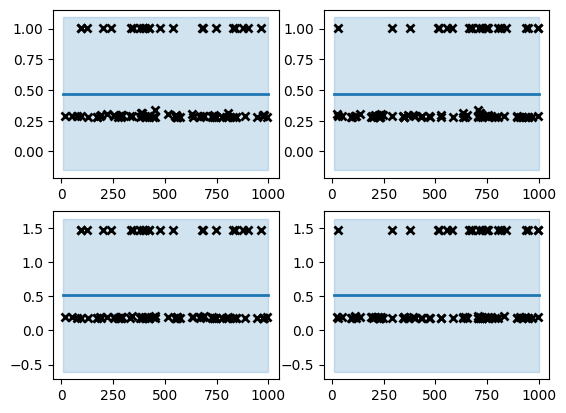

x_best =  [843.07428617 827.11012605]
acq_best =  [0.12409789 0.22267727]
C = [843.07428617 827.11012605]
Epoch 1/6
517/517 [==============================] - 4s 8ms/step - loss: 107109187584.0000 - mae: 210404.2969 - mse: 107109015552.0000 - val_loss: 59999911936.0000 - val_mae: 169689.9531 - val_mse: 59999715328.0000
Epoch 2/6
517/517 [==============================] - 5s 10ms/step - loss: 60548628480.0000 - mae: 164041.8750 - mse: 60548464640.0000 - val_loss: 56366489600.0000 - val_mae: 151841.3438 - val_mse: 56366329856.0000
Epoch 3/6
517/517 [==============================] - 6s 11ms/step - loss: 57846747136.0000 - mae: 159092.2188 - mse: 57846583296.0000 - val_loss: 52730519552.0000 - val_mae: 153046.1406 - val_mse: 52730376192.0000
Epoch 4/6
517/517 [==============================] - 5s 10ms/step - loss: 58428997632.0000 - mae: 160592.2344 - mse: 58428866560.0000 - val_loss: 52997726208.0000 - val_mae: 154172.8125 - val_mse: 52997574656.0000
Epoch 5/6
517/517 [==================

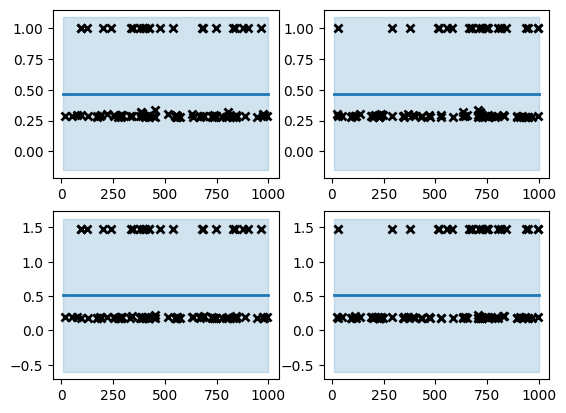

x_best =  [218.27848452 311.74341538]
acq_best =  [0.12360744 0.22178621]
C = [218.27848452 311.74341538]
Epoch 1/6
517/517 [==============================] - 3s 3ms/step - loss: 128586891264.0000 - mae: 227464.7188 - mse: 128586702848.0000 - val_loss: 97241513984.0000 - val_mae: 187334.5312 - val_mse: 97241341952.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 69507014656.0000 - mae: 170796.9531 - mse: 69506859008.0000 - val_loss: 57331965952.0000 - val_mae: 160167.0000 - val_mse: 57331806208.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 59874963456.0000 - mae: 162453.4219 - mse: 59874787328.0000 - val_loss: 54213394432.0000 - val_mae: 154915.3594 - val_mse: 54213246976.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 57810083840.0000 - mae: 160362.5156 - mse: 57809928192.0000 - val_loss: 54207598592.0000 - val_mae: 156381.6250 - val_mse: 54207442944.0000
Epoch 5/6
517/517 [=====================

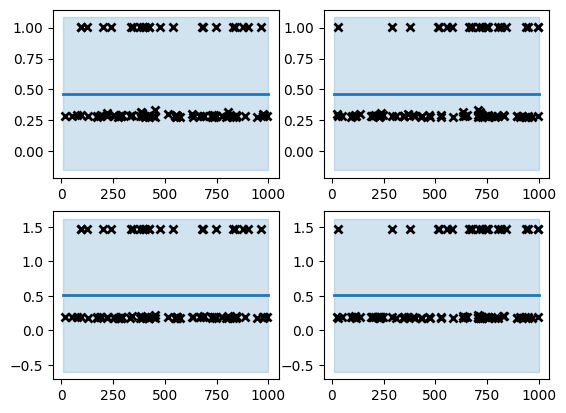

x_best =  [315.95828867 267.2797932 ]
acq_best =  [0.12314538 0.22095244]
C = [315.95828867 267.2797932 ]
Epoch 1/6
517/517 [==============================] - 2s 2ms/step - loss: 423041073152.0000 - mae: 538371.3750 - mse: 423040581632.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 423041040384.0000 - mae: 538371.1250 - mse: 423040647168.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 423041040384.0000 - mae: 538371.5625 - mse: 423040450560.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 423041269760.0000 - mae: 538371.4375 - mse: 423040745472.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
517/517 [=======

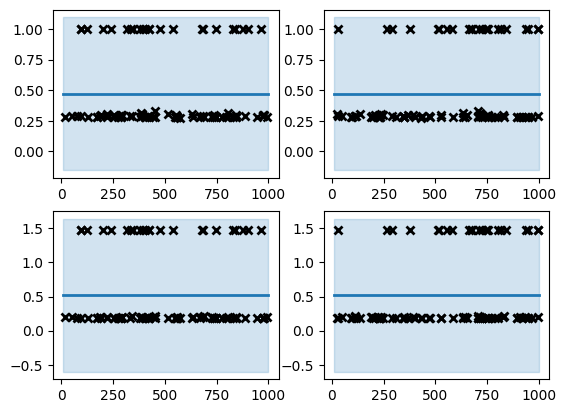

x_best =  [431.71508605  91.93667956]
acq_best =  [0.12453547 0.22344945]
C = [431.71508605  91.93667956]
Epoch 1/6
517/517 [==============================] - 2s 3ms/step - loss: 134183903232.0000 - mae: 233183.9688 - mse: 134183649280.0000 - val_loss: 84539056128.0000 - val_mae: 194662.1406 - val_mse: 84538843136.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 67094532096.0000 - mae: 166469.6250 - mse: 67094323200.0000 - val_loss: 56979386368.0000 - val_mae: 159224.0938 - val_mse: 56979202048.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 60106059776.0000 - mae: 162320.7344 - mse: 60105924608.0000 - val_loss: 55030575104.0000 - val_mae: 159466.7031 - val_mse: 55030419456.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 58391760896.0000 - mae: 160487.4062 - mse: 58391592960.0000 - val_loss: 57833996288.0000 - val_mae: 158731.4219 - val_mse: 57833840640.0000
Epoch 5/6
517/517 [=====================

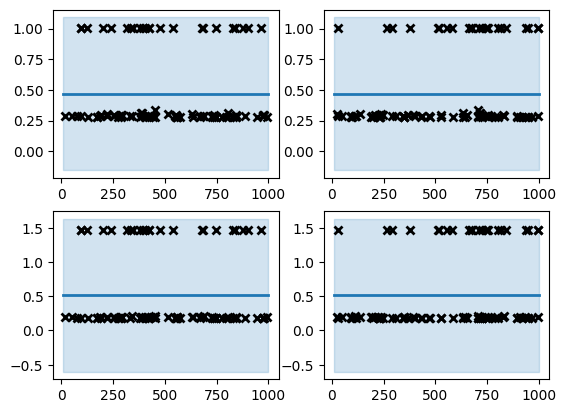

x_best =  [195.28675414 237.12922438]
acq_best =  [0.12408615 0.22261377]
C = [195.28675414 237.12922438]
Epoch 1/6
517/517 [==============================] - 2s 3ms/step - loss: 139754848256.0000 - mae: 239623.3750 - mse: 139754602496.0000 - val_loss: 104247697408.0000 - val_mae: 196435.5625 - val_mse: 104247468032.0000
Epoch 2/6
517/517 [==============================] - 2s 3ms/step - loss: 73107513344.0000 - mae: 172892.3906 - mse: 73107316736.0000 - val_loss: 57011638272.0000 - val_mae: 159651.9844 - val_mse: 57011470336.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 60355055616.0000 - mae: 163219.0156 - mse: 60354875392.0000 - val_loss: 61396746240.0000 - val_mae: 165619.1250 - val_mse: 61396574208.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 58763382784.0000 - mae: 161473.3125 - mse: 58763231232.0000 - val_loss: 59763052544.0000 - val_mae: 173042.2656 - val_mse: 59762868224.0000
Epoch 5/6
517/517 [===================

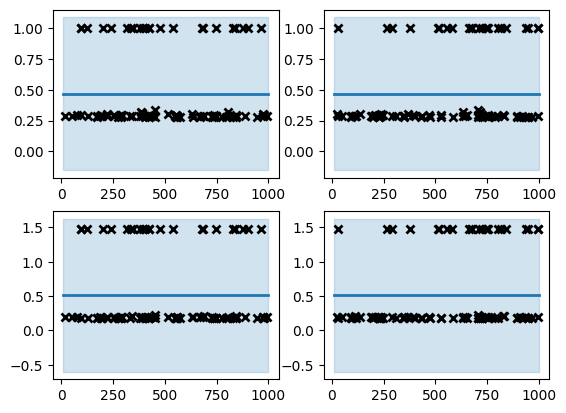

x_best =  [108.82950828 566.61867477]
acq_best =  [0.12363116 0.22180725]
C = [108.82950828 566.61867477]
Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 423041138688.0000 - mae: 538371.3750 - mse: 423040647168.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 423041302528.0000 - mae: 538371.6250 - mse: 423040679936.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 423041105920.0000 - mae: 538371.4375 - mse: 423040614400.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 423041269760.0000 - mae: 538371.3750 - mse: 423040548864.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
517/517 [=======

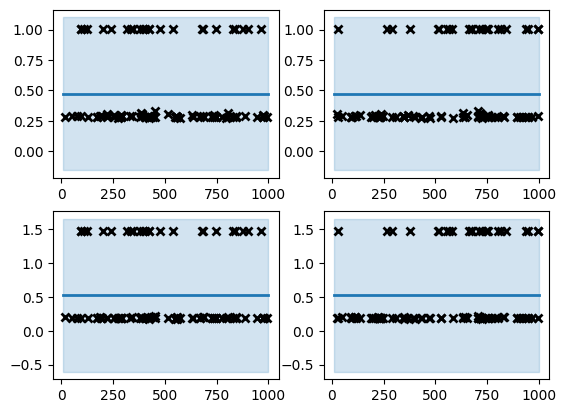

x_best =  [ 46.48142938 724.64612913]
acq_best =  [0.12495726 0.22418341]
C = [ 46.48142938 724.64612913]
Epoch 1/6
517/517 [==============================] - 2s 3ms/step - loss: 135893508096.0000 - mae: 235299.2188 - mse: 135893336064.0000 - val_loss: 114761482240.0000 - val_mae: 216431.3906 - val_mse: 114761277440.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 87554621440.0000 - mae: 186408.6562 - mse: 87554408448.0000 - val_loss: 65241264128.0000 - val_mae: 160936.6250 - val_mse: 65241083904.0000
Epoch 3/6
517/517 [==============================] - 1s 3ms/step - loss: 62368636928.0000 - mae: 163532.9688 - mse: 62368485376.0000 - val_loss: 61861445632.0000 - val_mae: 161243.8438 - val_mse: 61861294080.0000
Epoch 4/6
517/517 [==============================] - 1s 1ms/step - loss: 60513124352.0000 - mae: 162914.4844 - mse: 60513005568.0000 - val_loss: 57506271232.0000 - val_mae: 165574.0938 - val_mse: 57506082816.0000
Epoch 5/6
517/517 [===================

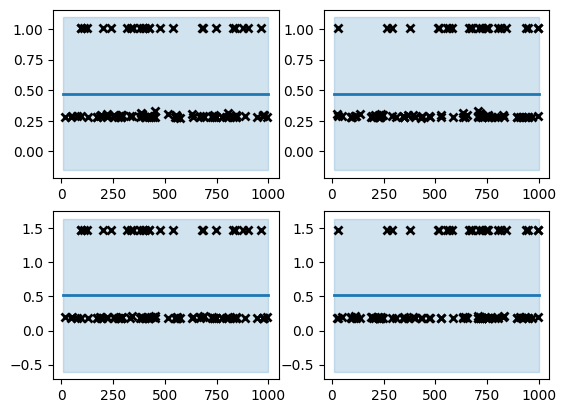

x_best =  [516.91301042 902.47570173]
acq_best =  [0.12452546 0.22338909]
C = [516.91301042 902.47570173]
Epoch 1/6
517/517 [==============================] - 5s 8ms/step - loss: 423041236992.0000 - mae: 538371.6250 - mse: 423040811008.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 3s 6ms/step - loss: 423041368064.0000 - mae: 538371.3125 - mse: 423040811008.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 3s 6ms/step - loss: 423041204224.0000 - mae: 538371.8125 - mse: 423040581632.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 3s 6ms/step - loss: 423041138688.0000 - mae: 538371.6875 - mse: 423040647168.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
517/517 [=======

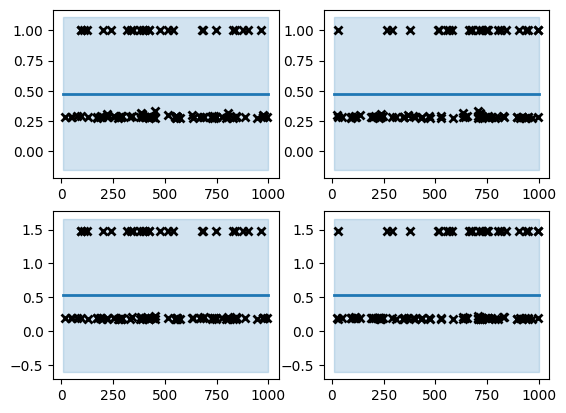

x_best =  [227.16826888 416.37819803]
acq_best =  [0.12577226 0.22563113]
C = [227.16826888 416.37819803]
Epoch 1/6
517/517 [==============================] - 3s 4ms/step - loss: 127211274240.0000 - mae: 226124.0000 - mse: 127211053056.0000 - val_loss: 88060157952.0000 - val_mae: 184966.9531 - val_mse: 88059994112.0000
Epoch 2/6
517/517 [==============================] - 2s 3ms/step - loss: 68483473408.0000 - mae: 169241.1562 - mse: 68483301376.0000 - val_loss: 57409470464.0000 - val_mae: 159789.6719 - val_mse: 57409323008.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 60311838720.0000 - mae: 162802.5781 - mse: 60311687168.0000 - val_loss: 55392067584.0000 - val_mae: 155196.9688 - val_mse: 55391916032.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 58327232512.0000 - mae: 160331.6562 - mse: 58327040000.0000 - val_loss: 55878385664.0000 - val_mae: 158427.6406 - val_mse: 55878238208.0000
Epoch 5/6
517/517 [=====================

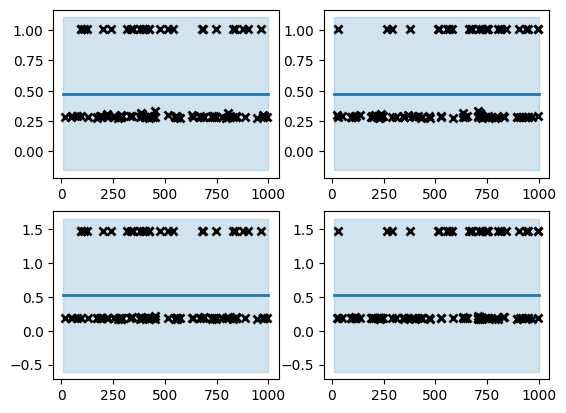

x_best =  [187.90221203 837.58290343]
acq_best =  [0.12534366 0.22486164]
C = [187.90221203 837.58290343]
Epoch 1/6
517/517 [==============================] - 2s 3ms/step - loss: 423041499136.0000 - mae: 538371.5625 - mse: 423040843776.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 2s 3ms/step - loss: 423041138688.0000 - mae: 538371.6250 - mse: 423040614400.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 2s 3ms/step - loss: 423041400832.0000 - mae: 538371.1875 - mse: 423040811008.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 423041105920.0000 - mae: 538371.4375 - mse: 423040614400.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
517/517 [=======

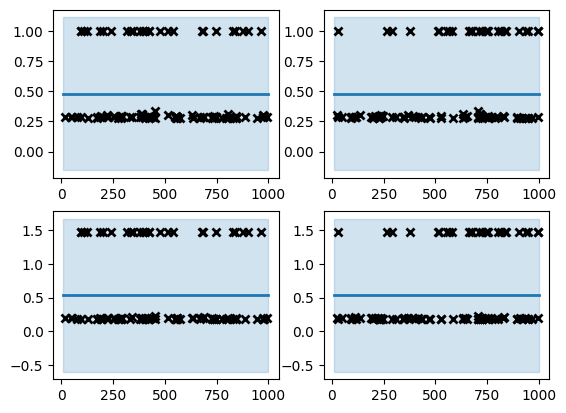

x_best =  [660.08656875 288.47723033]
acq_best =  [0.12653138 0.22696318]
C = [660.08656875 288.47723033]
Epoch 1/6
517/517 [==============================] - 3s 4ms/step - loss: 109387153408.0000 - mae: 208823.4062 - mse: 109386973184.0000 - val_loss: 60936257536.0000 - val_mae: 161948.0469 - val_mse: 60936105984.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 61957799936.0000 - mae: 163835.7188 - mse: 61957607424.0000 - val_loss: 55160639488.0000 - val_mae: 156108.3750 - val_mse: 55160483840.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 57798189056.0000 - mae: 159907.0000 - mse: 57798033408.0000 - val_loss: 57200291840.0000 - val_mae: 167408.4531 - val_mse: 57200123904.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 58161504256.0000 - mae: 160032.6562 - mse: 58161360896.0000 - val_loss: 52544385024.0000 - val_mae: 150724.7031 - val_mse: 52544249856.0000
Epoch 5/6
517/517 [=====================

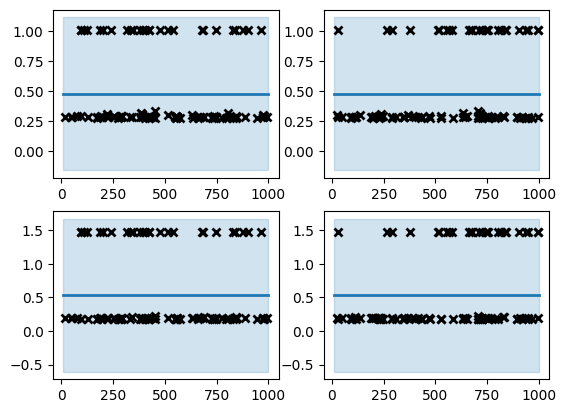

x_best =  [656.80625014 370.90800995]
acq_best =  [0.12616    0.22624678]
C = [656.80625014 370.90800995]
Epoch 1/6
517/517 [==============================] - 2s 3ms/step - loss: 113865736192.0000 - mae: 211861.6875 - mse: 113865523200.0000 - val_loss: 63792701440.0000 - val_mae: 163718.1562 - val_mse: 63792525312.0000
Epoch 2/6
517/517 [==============================] - 1s 3ms/step - loss: 62412967936.0000 - mae: 164564.6406 - mse: 62412804096.0000 - val_loss: 55227252736.0000 - val_mae: 152709.9844 - val_mse: 55227064320.0000
Epoch 3/6
517/517 [==============================] - 1s 3ms/step - loss: 57528274944.0000 - mae: 158600.9375 - mse: 57528123392.0000 - val_loss: 53174206464.0000 - val_mae: 150901.5938 - val_mse: 53174034432.0000
Epoch 4/6
517/517 [==============================] - 1s 3ms/step - loss: 57314676736.0000 - mae: 158171.0625 - mse: 57314508800.0000 - val_loss: 54004752384.0000 - val_mae: 154449.0312 - val_mse: 54004604928.0000
Epoch 5/6
517/517 [=====================

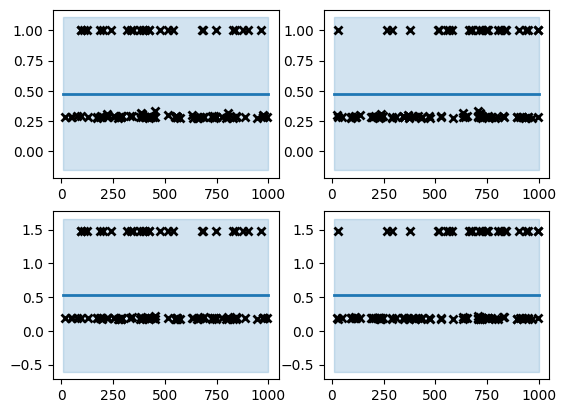

x_best =  [424.63048768 878.94049439]
acq_best =  [0.12574386 0.22552333]
C = [424.63048768 878.94049439]
Epoch 1/6
517/517 [==============================] - 3s 5ms/step - loss: 104993841152.0000 - mae: 207624.7188 - mse: 104993628160.0000 - val_loss: 59896315904.0000 - val_mae: 159327.8125 - val_mse: 59896131584.0000
Epoch 2/6
517/517 [==============================] - 3s 5ms/step - loss: 61439631360.0000 - mae: 164805.9375 - mse: 61439500288.0000 - val_loss: 57184673792.0000 - val_mae: 155739.5625 - val_mse: 57184530432.0000
Epoch 3/6
517/517 [==============================] - 3s 5ms/step - loss: 59214761984.0000 - mae: 162474.6094 - mse: 59214626816.0000 - val_loss: 54716964864.0000 - val_mae: 160688.8438 - val_mse: 54716801024.0000
Epoch 4/6
270/517 [==============>...............] - ETA: 1s - loss: 55840051200.0000 - mae: 158339.1719 - mse: 55839887360.0000

In [ ]:
savename = "MOONNHouses"

### GPs Initialization
GP = GaussianProcess(O, C, d, lowerBounds, upperBounds, noise_variance=2e-6)

#### Initial samples, at least 1
for l in range(initial_iter):
    ## Get random evaluation point
    while True:
        x_rand = np.random.uniform(lowerBounds[0], upperBounds[0], d)
        if GP.X is None or not x_rand in GP.X:
            break
    ## EVALUATION OF THE OUTSIDE FUNCTION
    
    y_rand = evaluation(x_rand)
    GP.X = np.array([x_rand], dtype=float)
    GP.Y = np.array([y_rand], dtype=float)    
    
GP.updateGP()
GP.optimizeKernel()

if False:
    GP.plotSamples()

for l in range(total_iter):

    ## For all acq functions but usemo
    # x_best, acq_best = mesmo_acq(GP)
    ## For usemo
    x_best, acq_best = usemo_acq(GP, function = "ei", showplots = False)
    print("x_best = ", x_best)
    print("acq_best = ", acq_best)
    ## EVALUATION OF THE OUTSIDE FUNCTION
    y_best = evaluation(x_best)

    ## UPDATE
    GP.addSample(x_best,y_best)     ## Add new sample to the model
    GP.updateGP()                   ## Update data on the GP regressor
    GP.optimizeKernel()             ## Optimize kernel hyperparameters

    print("Iteration=", l, " x_best=", x_best, "y=", y_best)
    GP.plot()
    

## Evaluate results

As you are doing a real world experiment you do not have access to the real pareto front, then you do not have your metrics as before (I removed them).

What you should evaluate is the results in terms of the best *y* possible. You have the data below, but you may do a pandas dataframe to store it cleaner when it is computed in the previous section.

GP.X === samples where the function was evaluated

GP.Y === results of those evaluations

In [ ]:
GP.X, GP.Y

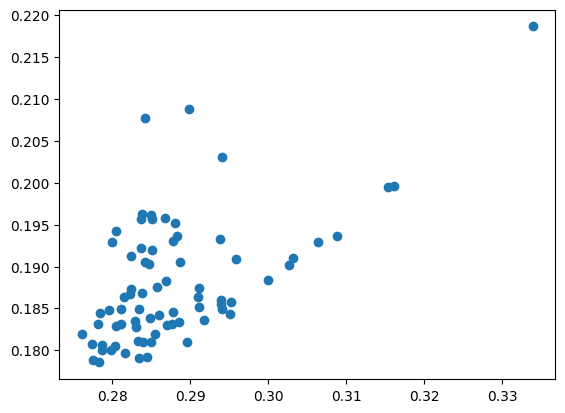

In [11]:
results = np.array([x for x in GP.Y if x[0]< 0.9])

plt.scatter(results[:,0],results[:,1])

In [12]:
results

array([[0.27828977, 0.17855899],
       [0.28957137, 0.18098728],
       [0.28302708, 0.18279663],
       [0.29178095, 0.18363081],
       [0.27838838, 0.18447225],
       [0.28382295, 0.19629771],
       [0.31528744, 0.19943281],
       [0.28390446, 0.18094978],
       [0.28494132, 0.18101278],
       [0.28675067, 0.19581936],
       [0.29377276, 0.19333059],
       [0.29395139, 0.18597664],
       [0.30875978, 0.19360639],
       [0.27957013, 0.1848439 ],
       [0.28046486, 0.18290775],
       [0.28113082, 0.18490796],
       [0.28028935, 0.18054476],
       [0.28333375, 0.18113391],
       [0.31605434, 0.19960792],
       [0.28466484, 0.19031136],
       [0.33390579, 0.21862958],
       [0.29395604, 0.18555622],
       [0.28767252, 0.18318324],
       [0.28340799, 0.17906553],
       [0.28161526, 0.1797111 ],
       [0.2823703 , 0.19128436],
       [0.2837469 , 0.18687141],
       [0.29586983, 0.19090059],
       [0.30317461, 0.19106226],
       [0.29997316, 0.18837944],
       [0.

In [ ]:
results = []
for c in np.linspace(0,0.1,100):
    results.append([c, MOOnnHousesRegression(c)])
    


In [ ]:
evs = [row[0] for row in results if row[1][0] < 500000]
mae = [row[1][0] for row in GP.Y if row[1][0] < 500000]
mse = [row[1][1] for row in results if row[1][0] < 500000]
plt.scatter(mae, mse)

In [ ]:
plt.scatter(evs, mae)

In [ ]:
mae

In [ ]:
results

In [ ]:
MOOnnHousesRegression(0)